# Deep Learning on EMNIST and mode collapse on GANs

[Part 1 - Anomaly Detection on Corrupted EMNIST](#anomaly-detection-on-corrupted-emnist)

[Part 2 - GAN and Mode Collapse on MNIST](#explore-mode-collapse-for-training-a-gan-on-mnist)

# Anomaly detection on corrupted EMNIST

## Unsupervised anomaly detection. Propose techniques to obtain anomaly detection.

- Try to explore at least 2 techniques
- Identify how the dataset has been corrupted

## Recovering the dataset.

For the corruption that you have identified and can be addressed, propose ways to "rebuild" the dataset.

## Evaluation

Propose metrics to quantify the improvement of your solution

We decided to first train an AutoEncoder (AE) on the corrupted dataset, and use the reconstruction error to identify corrupted images. Our assumption is that the higher the reconstruction error, the higher the probability of the image being corrupted.

## Loading data

In [ ]:
# We used Google Colab to collaborate and use GPUs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


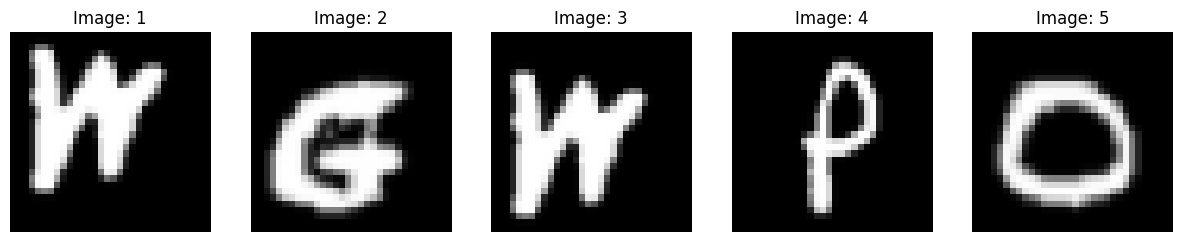

In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt

# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, 'r') as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)['all_imagesfinal']  # Load the array
    return data

# Load Corrupted EMNIST
# ZIP_PATH = '/content/drive/MyDrive/corrupted_emnist.zip'
ZIP_PATH = 'corrupted_emnist.zip' # Depending on file location
loaded_corrupted_images = load_images_from_zip(ZIP_PATH)

# Plot the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))

for i in range(5):
    image = loaded_corrupted_images[i]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image: {i + 1}")
    axes[i].axis('off')

plt.show()

In [ ]:
print(f"The dataset has {loaded_corrupted_images.shape[0]} images of size {loaded_corrupted_images.shape[1]}x{loaded_corrupted_images.shape[2]}")
print(f"Images are grayscale images with pixels taking values from {loaded_corrupted_images.min()} to {loaded_corrupted_images.max()}")

The dataset has 131057 images of size 32x32
Images are grayscale images with pixels taking values from 0.0 to 255.0


In [ ]:
# Let's normalize these images to use the Binary Croos-Entropy in a later phase
loaded_corrupted_images = loaded_corrupted_images / 255.0
print(f"Rescaled images have pixels taking values from {loaded_corrupted_images.min()} to {loaded_corrupted_images.max()}")

Rescaled images have pixels taking values from 0.0 to 1.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


Our first idea to extract corrupted images is to fit a classical AutoEncoder on the EMNIST corrupted data. As the bigger part of the data is uncorrupted, by training the AutoEncoder on the whole data, and using the reconstruction error (here the Binary Cross Entropy (BCE)) and a threshold on this error, we should be able to identify the corrupted images.

## Fitting an AE on the corrupted data

In [ ]:
# First we shuffle the whole dataset
loaded_corrupted_images_permuted = np.random.permutation(loaded_corrupted_images)

# Then we split the dataset into train and test
train_size = int(0.8 * len(loaded_corrupted_images_permuted))

train_data = torch.tensor(loaded_corrupted_images_permuted[:train_size],dtype=torch.float32)
test_data = torch.tensor(loaded_corrupted_images_permuted[train_size:],dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(
    train_data,batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_data,batch_size=10, shuffle=False)

In [ ]:
# We reuse the course's functions to plot the reconstructed images
# We adapt this code because we now have 32x32 images, versus 28x28 images previously

def to_img(x):
    # Convert tensor to NumPy array and move it to CPU
    x = x.cpu().data.numpy()
    # Rescale images to [0,1]
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    # Reshape images to 32x32 pixels
    x = x.reshape([-1, 32, 32])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set.
    The top row is the original digits,
    the middle row is the encoded vector,
    and the bottom row is the decoder reconstruction.
    """
    # Get a batch of test data
    data = next(iter(test_loader))
    # Flatten images to vectors
    data = data.view([-1, 1024])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    # Encode and then decode the images
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    # Convert images for plotting
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display encoded representations
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1, 4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


In [ ]:
# We create an AutoEncoder class with 2 hidden layers in the encoder and 2 in the decoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
            )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

We tried adding more layers to the AutoEncoder but it increased the loss, so we decided to go with this architecture.

In [ ]:
# Set input dimension (32x32 pixels) and encoding dimension
input_dim = 1024
encoding_dim = 64

# Initialize the AutoEncoder model
model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)

# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

We chose the BCEWithLogitsLoss because it gives better results when visualizing the results with the plot_reconstruction function.
So we decided to train an AutoEncoder with the BCEWithLogitsLoss to have the best model, and then use the same loss to identify the corrupted images.

In [ ]:
def train_model(model, loss_fn, data_loader=None, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, data in enumerate(train_loader):
            # Flatten the images into 32 * 32 = 1024 long vectors
            data = data.view([-1, 1024]).to(device)
            optimizer.zero_grad()
            # Forward pass through the model
            output = model(data)
            # Compute the loss between output and original input
            loss = loss_fn(output, data)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))


In [ ]:
# Train the model for 10 epochs
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)


Train Epoch: 0 [0/104845 (0%)]	Loss: 0.693638
Train Epoch: 0 [25600/104845 (24%)]	Loss: 0.281951
Train Epoch: 0 [51200/104845 (49%)]	Loss: 0.226755
Train Epoch: 0 [76800/104845 (73%)]	Loss: 0.180742
Train Epoch: 0 [102400/104845 (98%)]	Loss: 0.165503
Train Epoch: 1 [0/104845 (0%)]	Loss: 0.164212
Train Epoch: 1 [25600/104845 (24%)]	Loss: 0.154403
Train Epoch: 1 [51200/104845 (49%)]	Loss: 0.142675
Train Epoch: 1 [76800/104845 (73%)]	Loss: 0.139566
Train Epoch: 1 [102400/104845 (98%)]	Loss: 0.139346
Train Epoch: 2 [0/104845 (0%)]	Loss: 0.142776
Train Epoch: 2 [25600/104845 (24%)]	Loss: 0.136835
Train Epoch: 2 [51200/104845 (49%)]	Loss: 0.132792
Train Epoch: 2 [76800/104845 (73%)]	Loss: 0.132318
Train Epoch: 2 [102400/104845 (98%)]	Loss: 0.128367
Train Epoch: 3 [0/104845 (0%)]	Loss: 0.124556
Train Epoch: 3 [25600/104845 (24%)]	Loss: 0.128543
Train Epoch: 3 [51200/104845 (49%)]	Loss: 0.121018
Train Epoch: 3 [76800/104845 (73%)]	Loss: 0.117437
Train Epoch: 3 [102400/104845 (98%)]	Loss: 0.120

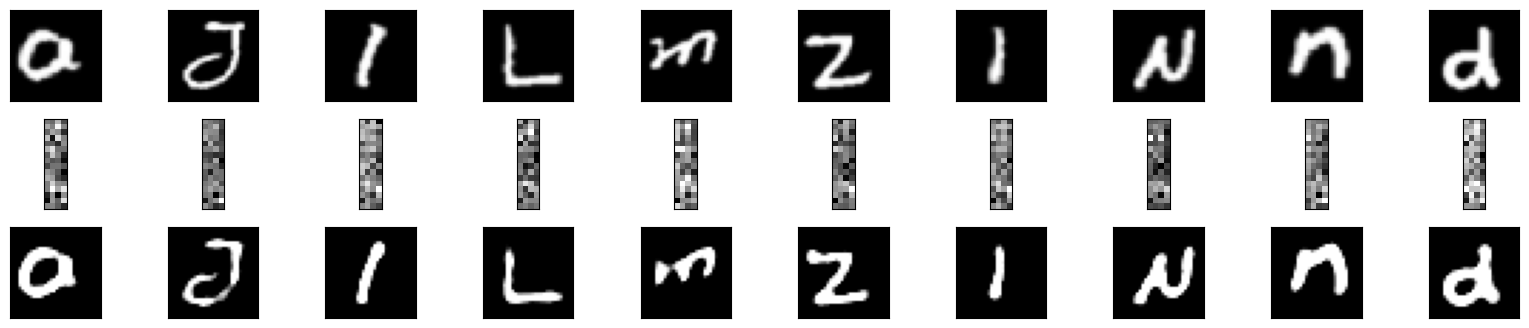

In [ ]:
# Visualize the reconstructed images
plot_reconstructions(model)

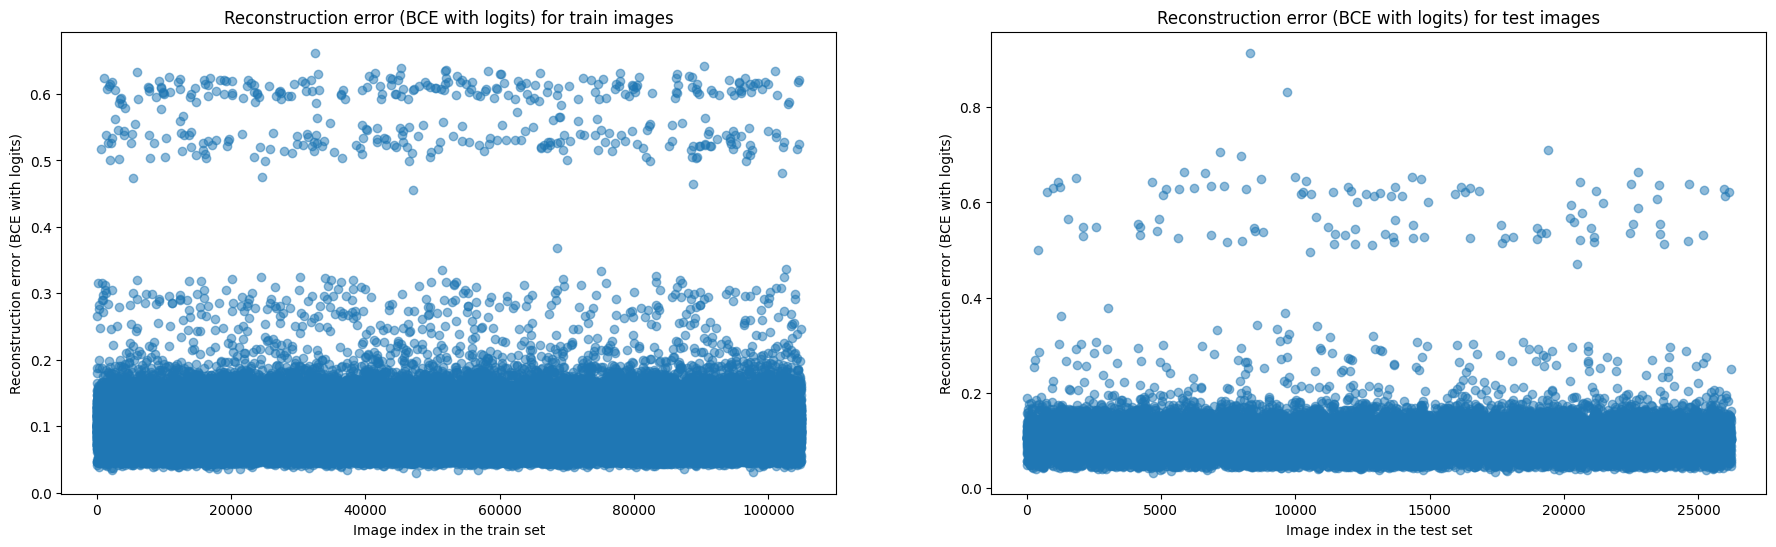

In [ ]:
def plot_reconstruction_errors(model, train_loader, test_loader, device):
    model.eval()
    bce_errors_train = []
    bce_errors_test = []

    with torch.no_grad():
        for data in train_loader:
            data = data.view(-1, 1024).to(device)

            # Reconstruct the images
            reconstructed = model(data)

            # Compute the BCEWithLogits reconstruction error for each image
            bce = F.binary_cross_entropy_with_logits(reconstructed, data, reduction='none')  # Per pixel
            bce_per_image = torch.mean(bce, dim=1)  # Average BCE per image
            bce_errors_train.extend(bce_per_image.cpu().numpy())  # Move to CPU and convert to numpy for plotting

        for data in test_loader:
            data = data.view(-1, 1024).to(device)

            # Reconstruct the images
            reconstructed = model(data)

            # Compute the BCEWithLogits reconstruction error for each image
            bce = F.binary_cross_entropy_with_logits(reconstructed, data, reduction='none')  # Per pixel
            bce_per_image = torch.mean(bce, dim=1)  # Average BCE per image
            bce_errors_test.extend(bce_per_image.cpu().numpy())  # Move to CPU and convert to numpy for plotting

    fig, axes = plt.subplots(1, 2, figsize=(22, 6))

    axes[0].plot(bce_errors_train, marker='o', linestyle='', alpha=0.5)
    axes[0].set_title(f"Reconstruction error (BCE with logits) for train images")
    axes[0].set_ylabel("Reconstruction error (BCE with logits)")
    axes[0].set_xlabel("Image index in the train set")
    axes[1].plot(bce_errors_test, marker='o', linestyle='', alpha=0.5)
    axes[1].set_title(f"Reconstruction error (BCE with logits) for test images")
    axes[1].set_ylabel("Reconstruction error (BCE with logits)")
    axes[1].set_xlabel("Image index in the test set")
    plt.show()

plot_reconstruction_errors(model, train_loader, test_loader, device)

Using this method, we clearly see that using the reconstruction error, images are split into 2 clusters:
*   the ones with a relatively low reconstruction error
*   the ones with a relatively high reconstruction error

Our first hypothesis is to take a threshold at BCE = 0.5, so we can hope to identify nearly all corrupted images.

Let us apply this threshold to the entire initial dataset to retrieve corrupted images.

### First hypothesis - threshold = 0.5

In [ ]:
corrupted_data_tensor = torch.tensor(loaded_corrupted_images,dtype=torch.float32)
data_loader = torch.utils.data.DataLoader(
    corrupted_data_tensor,batch_size=256, shuffle=False)

In [ ]:
model.eval()
bce_errors = []

with torch.no_grad():
    for data in data_loader:
        data = data.view(-1, 1024).to(device)

        # Reconstruct the images
        reconstructed = model(data)

        # Compute the BCEWithLogits reconstruction error for each image
        bce = F.binary_cross_entropy_with_logits(reconstructed, data, reduction='none')  # Per pixel
        bce_per_image = torch.mean(bce, dim=1)  # Average BCE per image
        bce_errors.extend(bce_per_image.cpu().numpy())  # Move to CPU and convert to numpy for plotting

In [ ]:
corrupted_images_index = []
original_images_index = []
for index, error in enumerate(bce_errors):
  if error > 0.5:
    corrupted_images_index.append(index)
  else:
    original_images_index.append(index)

corrupted_images = loaded_corrupted_images[corrupted_images_index]
original_images = loaded_corrupted_images[original_images_index]

Original images contains what we identified as uncorrupted images from the corrupted dataset, and corrupted images are what we identified as corrupted images from the dataset.

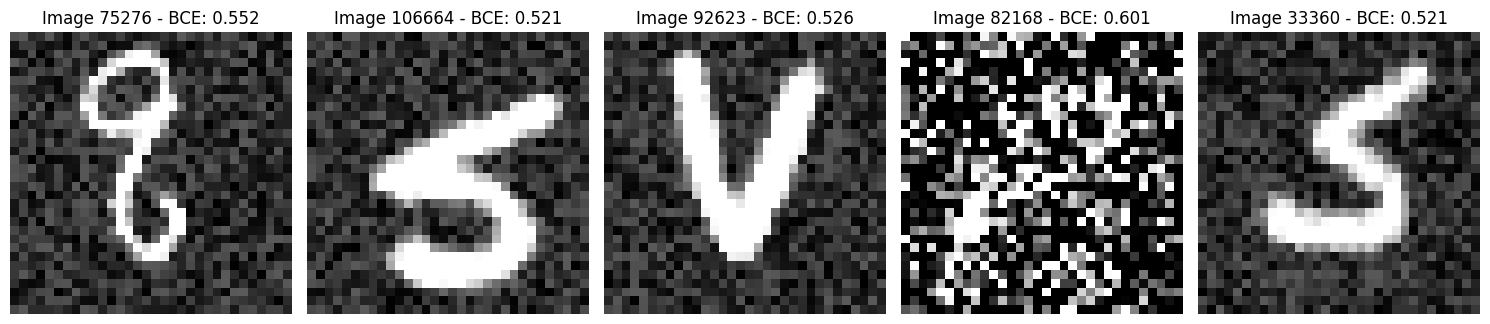

In [ ]:
import random

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random.sample(corrupted_images_index, 5)):
    image = loaded_corrupted_images[idx]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {idx + 1} - BCE: {bce_errors[idx]:.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

We clearly see that noise was added to the corrupted images that we plotted above.

Using this technique, we know that some images were corrupted by adding a significant amount of noise to them. We can detect them because we use a classical AE and we did not train it on noisy data. If we used a VAE for instance, we would not have catched these corrupted images because the VAE would surely have been able to reconstruct an image that looks like an original one, with no noise.

**We plotted all images and scrolled through them, and we found a little gift: the dall-e decoder saved with pickle.**

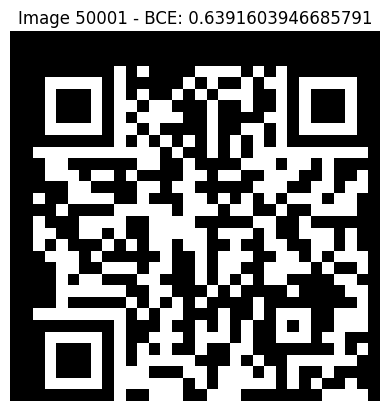

In [ ]:
plt.imshow(loaded_corrupted_images[50000], cmap='gray')
plt.title(f"Image {50001} - BCE: {bce_errors[50000]}")
plt.axis('off')
plt.show()

### Defining a better threshold

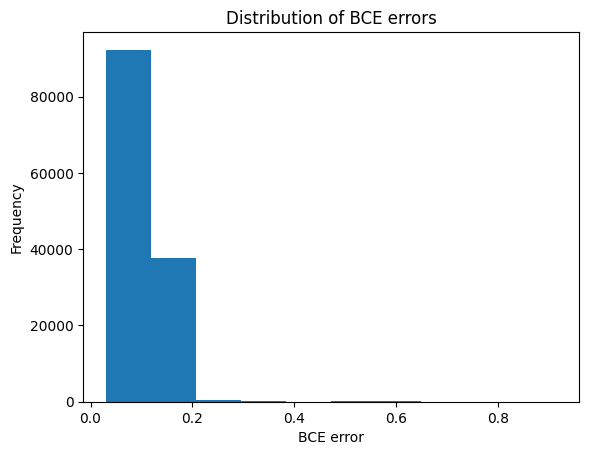

In [ ]:
# Let us plot the distribution of the errors
plt.hist(bce_errors, bins=10)
plt.title('Distribution of BCE errors')
plt.xlabel('BCE error')
plt.ylabel('Frequency')
plt.show()

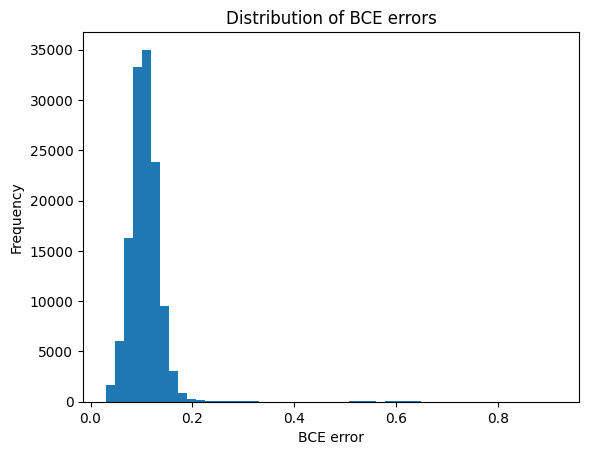

In [ ]:
# Let us plot the distribution of the errors with more detail
plt.hist(bce_errors, bins=50)
plt.title('Distribution of BCE errors')
plt.xlabel('BCE error')
plt.ylabel('Frequency')
plt.show()

Choosing a threshold a 0.5 made sense looking at the charts above. However, we could also have chosen a threshold at 0.2, considering most of the images had a reconstruction error under 0.2 as displayed in the chart above.

To understand how the remaining corrupted images were corrupted, let us analyze the images bin by bin with respect to the BCE error.

#### Error between 0.4 and 0.5

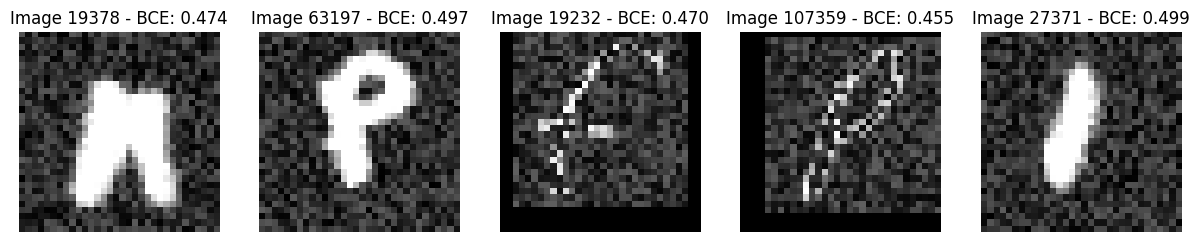

In [ ]:
images_index_with_relatively_high_error = []
images_with_relatively_high_error = []

for index, error in enumerate(bce_errors):
  if 0.4 < error <= 0.5:
    images_index_with_relatively_high_error.append(index)

images_with_relatively_high_error = loaded_corrupted_images[images_index_with_relatively_high_error]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random.sample(images_index_with_relatively_high_error, 5)):
    image = loaded_corrupted_images[idx]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {idx + 1} - BCE: {bce_errors[idx]:.3f}")
    axes[i].axis('off')

We have similar noisy images for images in this batch. They are less noisy that the ones with an error > 0.5 which makes sense.

#### Error between 0.3 and 0.4

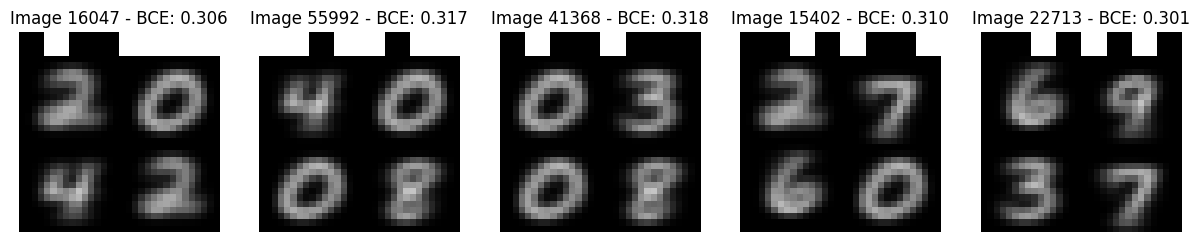

In [ ]:
images_index_with_relatively_high_error = []
images_with_relatively_high_error =[]

for index, error in enumerate(bce_errors):
  if 0.3 < error <= 0.4:
    images_index_with_relatively_high_error.append(index)

images_with_relatively_high_error = loaded_corrupted_images[images_index_with_relatively_high_error]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random.sample(images_index_with_relatively_high_error, 5)):
    image = loaded_corrupted_images[idx]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {idx + 1} - BCE: {bce_errors[idx]:.3f}")
    axes[i].axis('off')

Now we see another type of corrupted iamges:
*   EMNIST images have only a single character per image. Here we see images with **4 blurred characters and parts of the image were cropped**.
*   We also see for image 13045 that some images had a **color inversion transformation**.



#### Error between 0.2 and 0.3

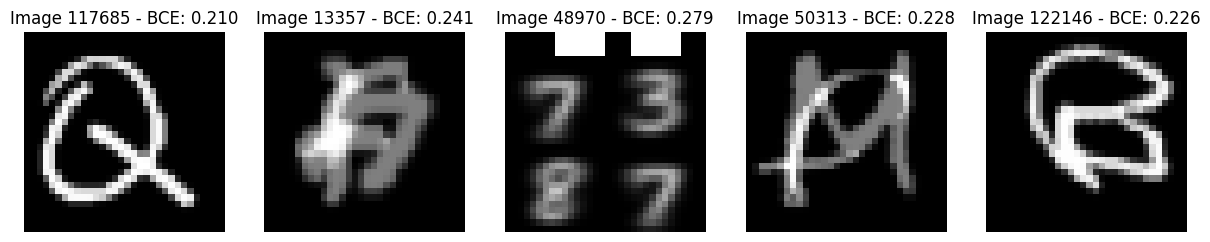

In [ ]:
images_index_with_relatively_high_error = []
images_with_relatively_high_error =[]

for index, error in enumerate(bce_errors):
  if 0.2 < error <= 0.3:
    images_index_with_relatively_high_error.append(index)

images_with_relatively_high_error = loaded_corrupted_images[images_index_with_relatively_high_error]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random.sample(images_index_with_relatively_high_error, 5)):
    image = loaded_corrupted_images[idx]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {idx + 1} - BCE: {bce_errors[idx]:.3f}")
    axes[i].axis('off')

We see similar corruptions with respect to the previous bin.

Image 2337 could be a new transformation: it has been blurred nearly everywhere.

#### Error between 0.15 and 0.2

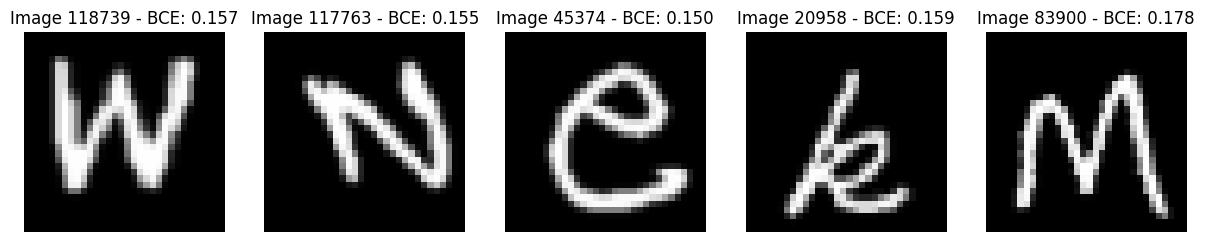

In [ ]:
images_index_with_relatively_high_error = []
images_with_relatively_high_error = []

for index, error in enumerate(bce_errors):
  if 0.15 < error <= 0.2:
    images_index_with_relatively_high_error.append(index)

images_with_relatively_high_error = loaded_corrupted_images[images_index_with_relatively_high_error]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random.sample(images_index_with_relatively_high_error, 5)):
    image = loaded_corrupted_images[idx]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {idx + 1} - BCE: {bce_errors[idx]:.3f}")
    axes[i].axis('off')

These images don't seem to have been corrupted. So we can confidently move the threshold to 0.2.

### Additional analysis

Instead of using arbitrary thresholds, let's use a clustering approach to identify the different groups of transformations.

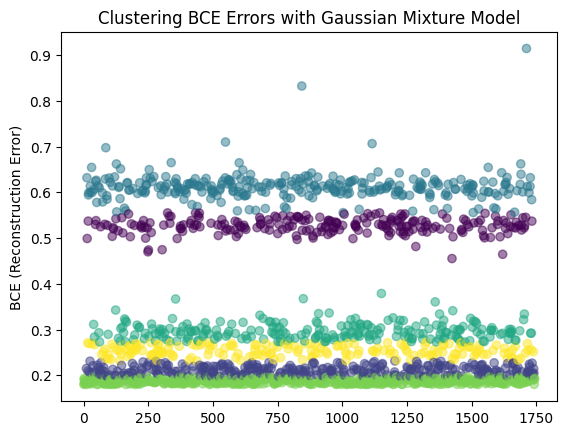

In [ ]:
from sklearn.mixture import GaussianMixture

bce_errors_thresh = []
bce_errors_thresh_index = []
for i,error in enumerate(bce_errors):
  if error > 0.18:
    bce_errors_thresh.append(error)
    bce_errors_thresh_index.append(i)
bce_errors_thresh = np.array(bce_errors_thresh)
bce_errors_thresh = bce_errors_thresh.reshape(-1, 1)
gmm = GaussianMixture(n_components=6, random_state=0)
clusters = gmm.fit_predict(bce_errors_thresh)
plt.scatter(range(len(bce_errors_thresh)), bce_errors_thresh, c=clusters, cmap='viridis', alpha=0.5)
plt.ylabel("BCE (Reconstruction Error)")
plt.title("Clustering BCE Errors with Gaussian Mixture Model")
plt.show()

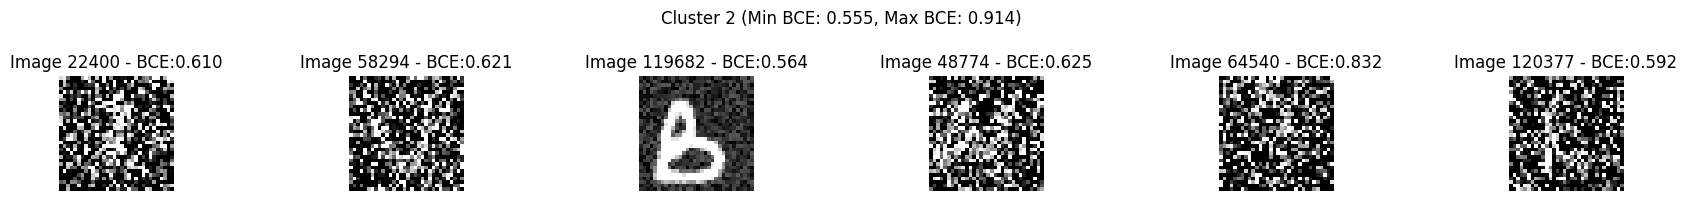

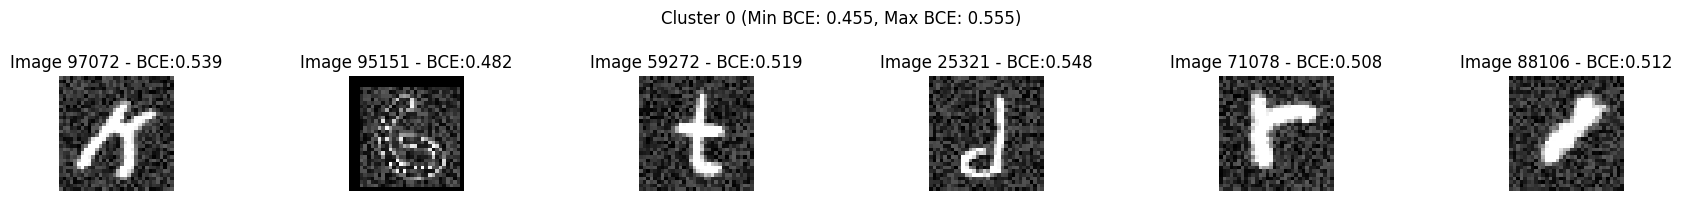

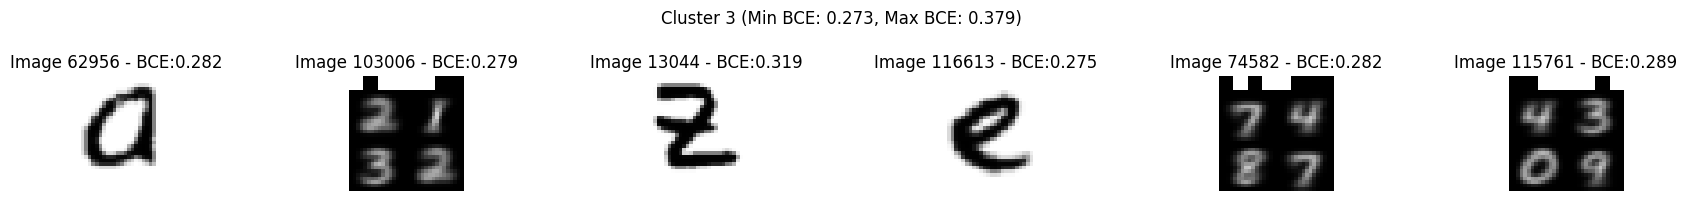

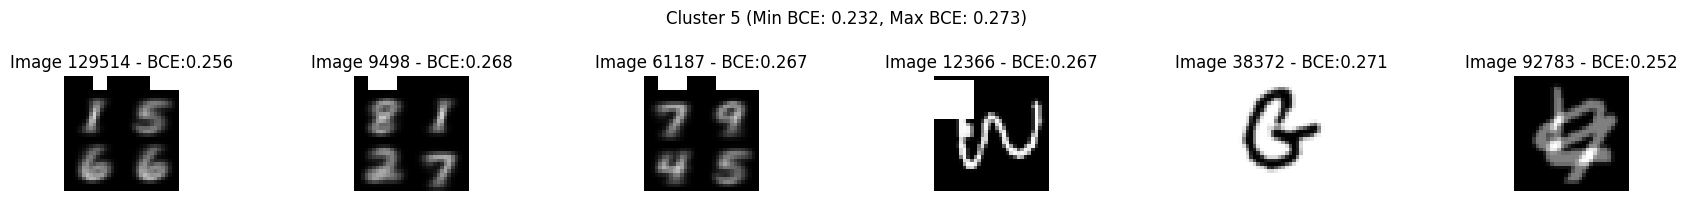

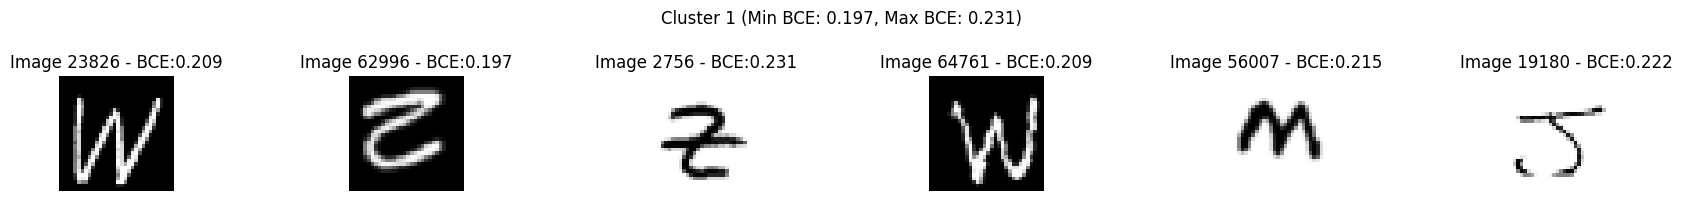

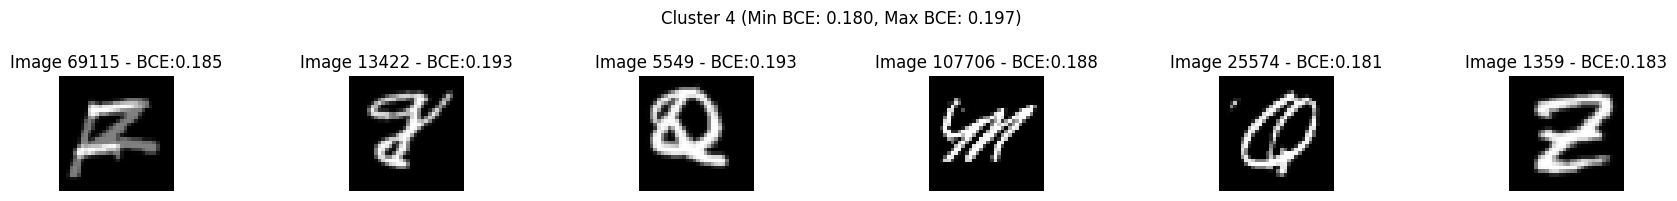

In [ ]:
cluster_min_bce = {cluster_id: np.min(bce_errors_thresh[clusters == cluster_id]) for cluster_id in range(6)}
cluster_max_bce = {cluster_id: np.max(bce_errors_thresh[clusters == cluster_id]) for cluster_id in range(6)}

sorted_clusters = sorted(cluster_max_bce.keys(), key=lambda x: cluster_max_bce[x], reverse=True)

n_images_per_cluster = 6

for cluster_id in sorted_clusters:
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Randomly select images from the cluster
    selected_indices = random.sample(list(cluster_indices), min(n_images_per_cluster, len(cluster_indices)))

    img_idx = [bce_errors_thresh_index[i] for i in selected_indices]

    # Plot the selected images
    fig, axes = plt.subplots(1, n_images_per_cluster, figsize=(18, 2))
    for i, idx in enumerate(img_idx):
        img = loaded_corrupted_images[idx]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Image {idx} - BCE:{bce_errors[idx]:.3f}")
        axes[i].axis('off')

    min_bce = cluster_min_bce[cluster_id]
    max_bce = cluster_max_bce[cluster_id]
    plt.suptitle(f"Cluster {cluster_id} (Min BCE: {min_bce:.3f}, Max BCE: {max_bce:.3f})")
    plt.tight_layout()
    plt.show()

We added the last cluster because it allows us to identify the right threshold

By reasoning with clustering on the reconstruction error, we see that the reconstruction error depends on the type of transformation that was made.
We identify the following transofrmations:
 using the following techniques:
*   Adding a lot of noise to original images
*   Adding some noise to original images
*   Using 4 original images, decreasing their size and creating an image from these 4 characters, and then cropping parts of this image
*   Blurring of entire or parts of images
*   Color inversion
*   Images with missing / cropped parts
*   Color inversion + adding a black padding around the image
*   Images that were generated by sampling between two classes in the latent space as seen it class

In [ ]:
new_threshold = cluster_min_bce[sorted_clusters[-2]]
print(f"Using this method, the new threhsold should be {new_threshold:.3f}, which is the minimum error of the last cluster of corrupted images.")

Using this method, the new threhsold should be 0.197, which is the minimum error of the last cluster of corrupted images.


### Final datasets

Depending on the error value, we have different techniques of corruption used. It makes sense that the images with a lot of added noise are the ones with the highest reconstruction error, because the AE does not "recognize" any feature it learned from training on uncorrupted images.

You can access the corrupted (corrupted_images) and original (original_images) datasets defined hereunder.

In [ ]:
corrupted_images_index_final = []
original_images_index_final = []
for index, error in enumerate(bce_errors):
  if error > new_threshold:
    corrupted_images_index_final.append(index)
  else:
    original_images_index_final.append(index)

corrupted_images = loaded_corrupted_images[corrupted_images_index_final]
original_images = loaded_corrupted_images[original_images_index_final]


# Let's check if we clustered all images
if len(corrupted_images) + len(original_images) == len(loaded_corrupted_images):
  print("We clustered all images")
print(f"With a threhsold of BCE={new_threshold:.3f}, we identified {len(corrupted_images)} corrupted images and {len(original_images)} original images")

We clustered all images
With a threhsold of BCE=0.197, we identified 1252 corrupted images and 129805 original images


Using this method, we think that 1285 images were corrupted. We may have included uncorrupted images in the corrupted set, but we preferred to be strict and minimize the false negative (negative being non corrupted).





Maybe using a VAE, we would find other types of corrupted images that the current AE did not find. Let us try that out.

## Implement a VAE to detect anomaly

We decided to train a VAE on the clear EMNIST data to look at the reconstrcution error obtain it with corrupted EMNIST data.

Normally we expect to see a clearer separation than on the previous auto encoder.

In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt

# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, 'r') as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)['all_imagesfinal']  # Load the array
    return data

# Example usage
loaded_corrupted_images = load_images_from_zip('/content/corrupted_emnist.zip')

loaded_corrupted_images = loaded_corrupted_images / 255.0

### 1. *Download* the data

First we downlaod and unzip the clear EMNIST data

In [ ]:
#Download
!wget https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip

--2024-12-13 09:36:11--  https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip
Resolving biometrics.nist.gov (biometrics.nist.gov)... 18.235.227.114
Connecting to biometrics.nist.gov (biometrics.nist.gov)|18.235.227.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561753746 (536M) [application/zip]
Saving to: ‘gzip.zip’

gzip.zip            100%[===================>] 535.73M  18.3MB/s    in 32s     

2024-12-13 09:36:44 (16.9 MB/s) - ‘gzip.zip’ saved [561753746/561753746]



In [ ]:
# Unzip
import os

zip_file = 'gzip.zip'
target_folder = 'emnist_data'

os.makedirs(target_folder, exist_ok=True)

# Extract files from the ZIP archive
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    for file in zip_ref.namelist():
        extracted_path = os.path.join(target_folder, os.path.relpath(file, start="gzip"))
        os.makedirs(os.path.dirname(extracted_path), exist_ok=True)
        with zip_ref.open(file) as source, open(extracted_path, "wb") as target:
            target.write(source.read())

We use ChatGPT to help us develop the `EMNIST` class, it enables us to access easily and the same way as in the class the EMNIST dataset through a pytorch data_loader

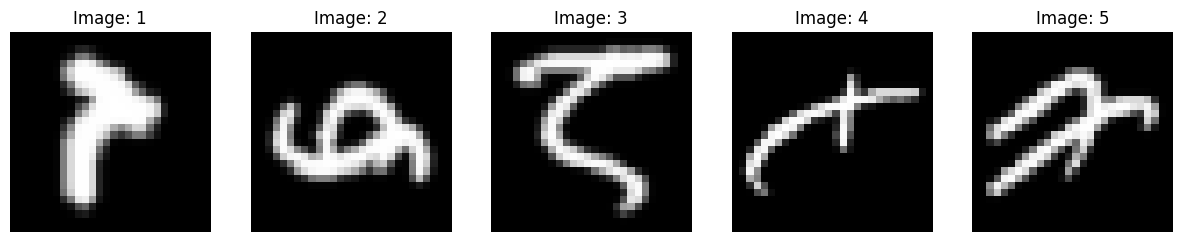

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import gzip
import struct
from PIL import Image
from io import BytesIO

class EMNIST(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        """
        Args:
            image_file (str): Path to the .gz file containing image data.
            label_file (str): Path to the .gz file containing label data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_file = image_file
        self.label_file = label_file
        self.transform = transform

        # Load data
        self.images = self._load_images()
        self.labels = self._load_labels()

    def _load_images(self):
        with gzip.open(self.image_file, 'rb') as f:
            # Read magic number, number of images, rows, cols
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        return images

    def _load_labels(self):
        with gzip.open(self.label_file, 'rb') as f:
            # Read magic number, number of labels
            magic, num_labels = struct.unpack('>II', f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PIL Image for transformations (if any)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image#, label


image_file = '/content/emnist_data/emnist-balanced-train-images-idx3-ubyte.gz'
label_file = '/content/emnist_data/emnist-balanced-train-labels-idx1-ubyte.gz'


# Initialize the dataset
emnist_dataset = EMNIST(image_file=image_file, label_file=label_file)

# Display the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))

for i in range(5):
    image = emnist_dataset[i]
    image = np.array(image).squeeze()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image: {i + 1}")
    axes[i].axis('off')

plt.show()

### 2. Preprocess data

Since the shape of the corrupted data is (32x32), we need to resize it.

Our first idea was to add pixel to map the shape using padding (adding 2 pixels on each direction). But due to repeated errors we decided to use the `Resize` method from `torchvision.transforms`

In [ ]:
from torchvision import transforms

# Class not used
class AddPadding32x32:
    def __init__(self, target_size=(32, 32)):
        self.target_size = target_size

    def __call__(self, image):
        image_tensor = transforms.ToTensor()(image)

        _, h, w = image_tensor.shape
        pad_top = (self.target_size[0] - h) // 2
        pad_bottom = self.target_size[0] - h - pad_top
        pad_left = (self.target_size[1] - w) // 2
        pad_right = self.target_size[1] - w - pad_left

        padded_image = F.pad(image_tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)

        return padded_image


transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match corrupted image size
    transforms.ToTensor(),        # Convert images to Tensor (and normalized it to [0, 1])
])

emnist_dataset = EMNIST(image_file=image_file, label_file=label_file, transform=transform)

### 3. Implement VAE

We reuse the code developped during the LAB to implement a VAE to fit on the clear EMNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.input_size = input_dim

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # Mean of latent variables
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance of latent variables

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # Encode input to hidden representation
        h1 = F.relu(self.fc1(x))
        # Get mean and log variance for latent variables
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from N(mu, var) using N(0,1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random normal tensor
        return mu + eps * std

    def decode(self, z):
        # Decode latent variables back to input space
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # Use sigmoid to get outputs between 0 and 1

    def forward(self, x):
        # Forward pass through encoder, reparameterization, and decoder
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1024), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### 4. Train the VAE on clear EMNIST dataset

We instatiate the data laoder object to train our VAE

In [ ]:
batch_size = 256
train_loader = DataLoader(emnist_dataset, batch_size=batch_size, shuffle=True)

We train our VAE

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [ ]:
import torch.optim as optim

input_dim = 1024

vae_model = VAE(input_dim=input_dim).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

def train_vae(model, loss_fn, data_loader, epochs, optim):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.view(-1, input_dim).to(device)
        optim.zero_grad()
        # Forward pass
        recon_batch, mu, logvar = model(data)
        # Compute loss
        loss = loss_fn(recon_batch, data, mu, logvar)
        # Backward pass and optimization
        loss.backward()
        train_loss += loss.item()
        optim.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))


In [ ]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_vae(vae_model, loss_function, train_loader, num_epochs, optimizer)

Train Epoch: 1 [0/112800 (0%)]	Loss: 719.543030
Train Epoch: 1 [25600/112800 (23%)]	Loss: 308.009949
Train Epoch: 1 [51200/112800 (45%)]	Loss: 270.471405
Train Epoch: 1 [76800/112800 (68%)]	Loss: 236.923584
Train Epoch: 1 [102400/112800 (91%)]	Loss: 235.756226
====> Epoch: 1 Average loss: 284.4799
Train Epoch: 2 [0/112800 (0%)]	Loss: 235.176849
Train Epoch: 2 [25600/112800 (23%)]	Loss: 231.494247
Train Epoch: 2 [51200/112800 (45%)]	Loss: 223.328751
Train Epoch: 2 [76800/112800 (68%)]	Loss: 219.014236
Train Epoch: 2 [102400/112800 (91%)]	Loss: 227.437653
====> Epoch: 2 Average loss: 226.9924
Train Epoch: 3 [0/112800 (0%)]	Loss: 224.918655
Train Epoch: 3 [25600/112800 (23%)]	Loss: 222.450287
Train Epoch: 3 [51200/112800 (45%)]	Loss: 218.838501
Train Epoch: 3 [76800/112800 (68%)]	Loss: 221.364365
Train Epoch: 3 [102400/112800 (91%)]	Loss: 214.224884
====> Epoch: 3 Average loss: 220.4550
Train Epoch: 4 [0/112800 (0%)]	Loss: 218.043823
Train Epoch: 4 [25600/112800 (23%)]	Loss: 220.154587
Tr

### 5. Analyze the reconstruction errors

First, we need to instantiate our corrupted loader based on corrupted images

In [ ]:
batch_size = 256
corrupted_tensor = torch.tensor(loaded_corrupted_images, dtype=torch.float32)
corrupted_loader = torch.utils.data.DataLoader(corrupted_tensor, batch_size=batch_size)

Reconstruct the errors from the corrupted data

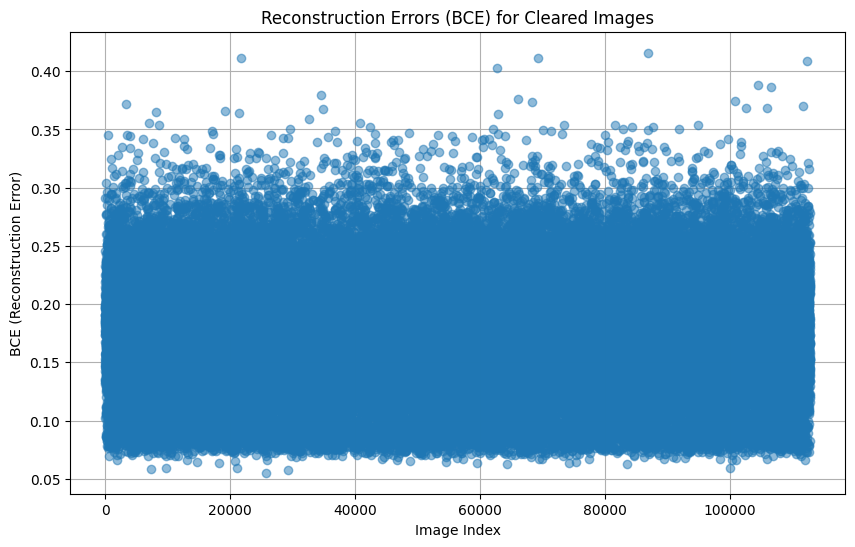

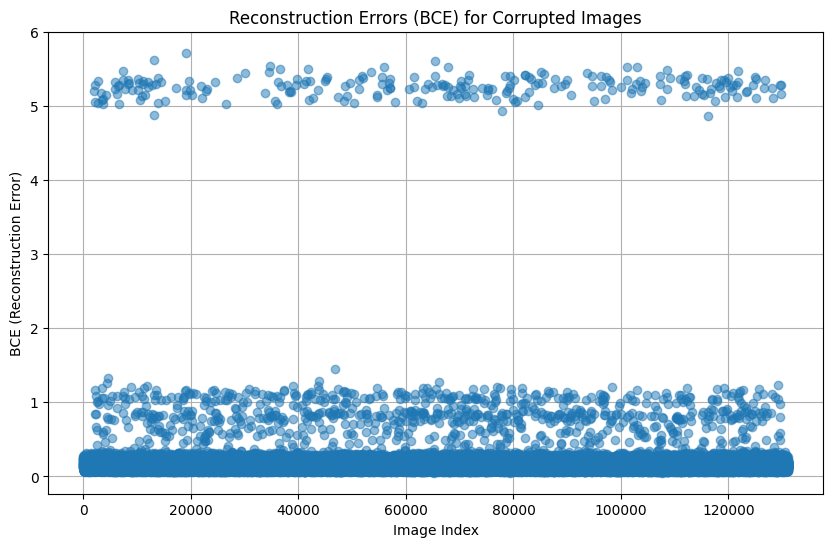

In [ ]:
def plot_reconstruction_errors_bce(model, data_loader, device, dataset='Train'):
    model.eval()
    bce_errors = []

    with torch.no_grad():
        for data in data_loader:
            data = data.view(-1, 1024).to(device)

            # Reconstruct the images
            reconstructed, _, _ = model(data)

            # Compute the BCEWith reconstruction error for each image
            bce = F.binary_cross_entropy(reconstructed, data, reduction='none')
            bce_per_image = torch.mean(bce, dim=1)
            bce_errors.extend(bce_per_image.cpu().numpy())

    # Plot the reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.plot(bce_errors, marker='o', linestyle='', alpha=0.5)
    plt.title(f'Reconstruction Errors (BCE) for {dataset} Images')
    plt.xlabel('Image Index')
    plt.ylabel('BCE (Reconstruction Error)')
    plt.grid(True)
    plt.show()

    return bce_errors

bce_err_clear = plot_reconstruction_errors_bce(vae_model, train_loader, device, dataset='Cleared')
bce_err_corrupt = plot_reconstruction_errors_bce(vae_model, corrupted_loader, device, dataset='Corrupted')

#### Error above 4

To verify, we try to display the corrupted images since we clearly see a separation on the Reconstruction errror above 4

In [ ]:
threshold = 4
corrupted_idx = [i for i, v in enumerate(bce_err_corrupt) if v > threshold]
print(f'There are {len(corrupted_idx)} corrupted images with a reconstruction higher than {threshold}')

There are 241 corrupted images with a reconstruction higher than 4


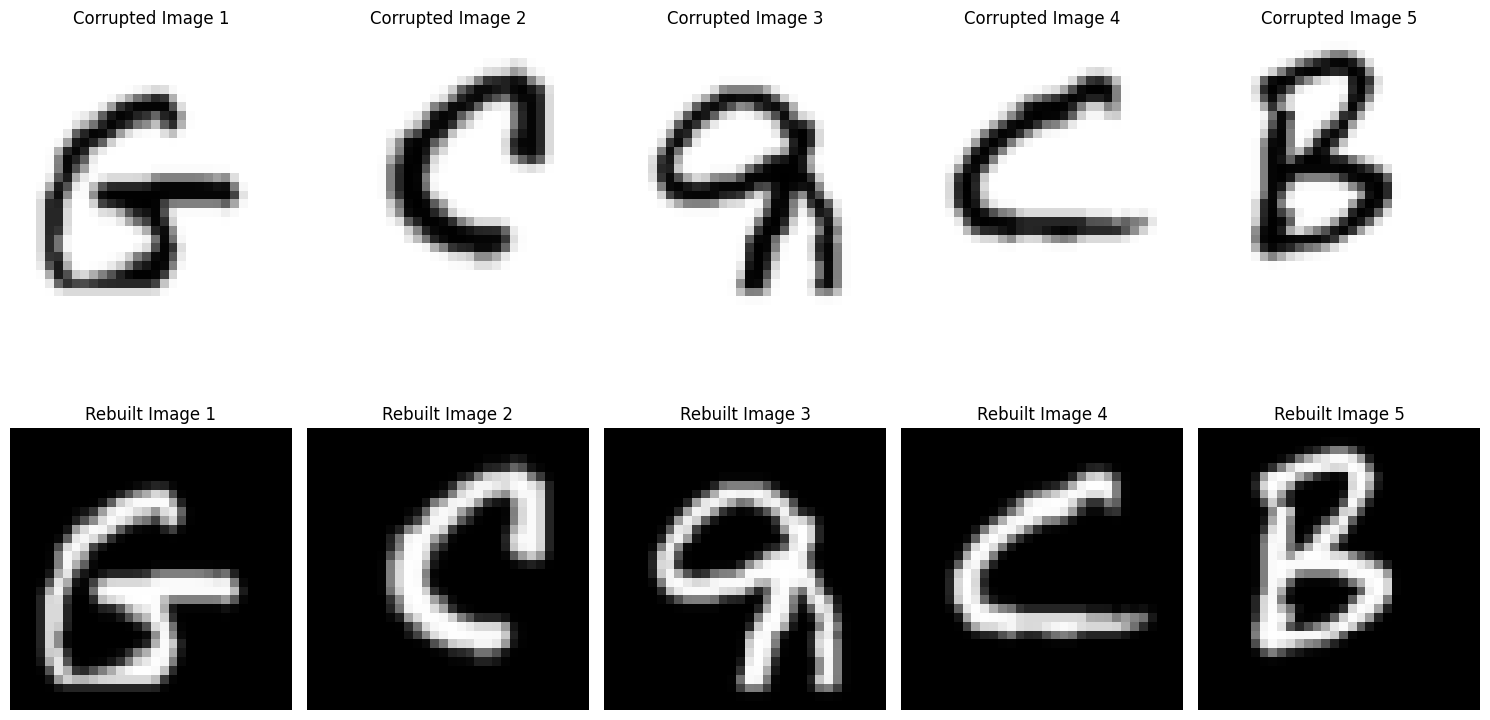

In [ ]:
import random

nb_img = 5
fig, axes = plt.subplots(2, nb_img, figsize=(15, 9))
axes = axes.flatten()
for i, idx in enumerate(random.sample(corrupted_idx, nb_img)):
  img = loaded_corrupted_images[idx]
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Corrupted Image {i+1}")
  axes[i].axis('off')

  axes[5+i].imshow(1 - img, cmap='gray')
  axes[5+i].set_title(f"Rebuilt Image {i+1}")
  axes[5+i].axis('off')
plt.tight_layout()

Thanks to this plot we understand that corrupted EMNIST contains image with inverted pixels (Black letter on a white background)

#### Investigate others anomaly

To investigate others anomaly like the one seen in the previous section with the AutoEncoder, we need to reconstruct the image inverting the pixels.

Then we can better investigate the reconstruction errors since there are less corrupted images.

In [ ]:
corrupted_images_without_invert = loaded_corrupted_images.copy()
for idx in corrupted_idx:
  # To invert pixel
  corrupted_images_without_invert[idx] = 1 - corrupted_images_without_invert[idx]

In [ ]:
batch_size = 256
corrupted_tensor_without_invert = torch.tensor(corrupted_images_without_invert, dtype=torch.float32)
corrupted_loader_without_invert = torch.utils.data.DataLoader(corrupted_tensor_without_invert, batch_size=batch_size)

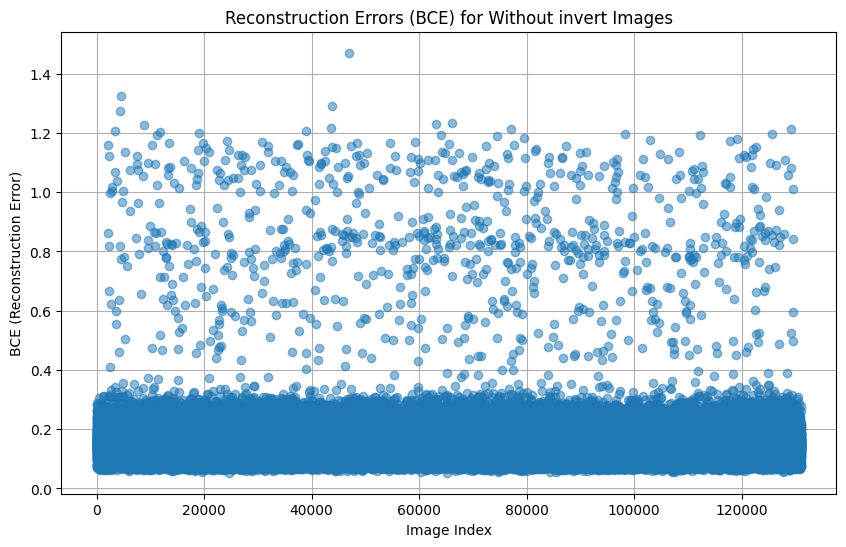

In [ ]:
bce_err_wo_invert = plot_reconstruction_errors_bce(vae_model, corrupted_loader_without_invert, device, dataset='Without invert')

As before, we observe a zone, where $BCE < 0.4$, corresponding to uncorrupted images as we can see in the Reconstruction Errors (BCE) for clear Images plot.

And then we observe zones between $1$ and $1.2$ or around $0.8$ which would seem to correspond to a different type of corruption respectively.

To confirm our thought we display below an histogram to visualize potential threshold

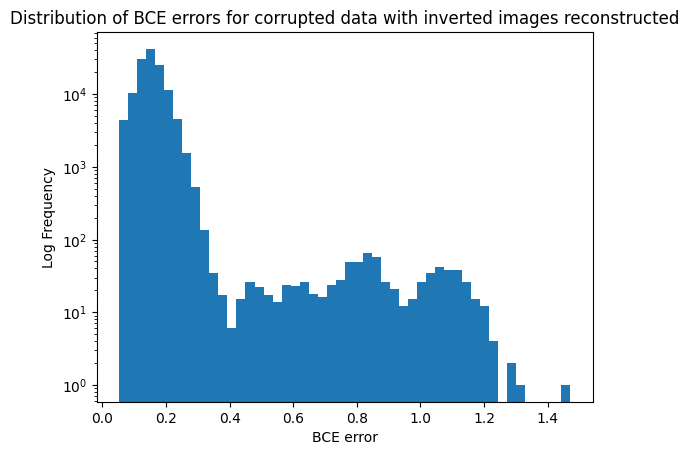

In [ ]:
# Let us plot the distribution of the errors
plt.hist(bce_err_wo_invert, bins=50, log=True)
plt.title('Distribution of BCE errors for corrupted data with inverted images reconstructed')
plt.xlabel('BCE error')
plt.ylabel('Log Frequency')
plt.show()

We decided to focus only on images with a reconstruction errors above $0.4$.

In [ ]:
threshold = .4
corrupted_idx_above_04 = [i for i, v in enumerate(bce_err_wo_invert) if v > threshold]
print(f'There are {len(corrupted_idx_above_04)} corrupted images with a reconstruction errors higher than {threshold}')

There are 792 corrupted images with a reconstruction errors higher than 0.4


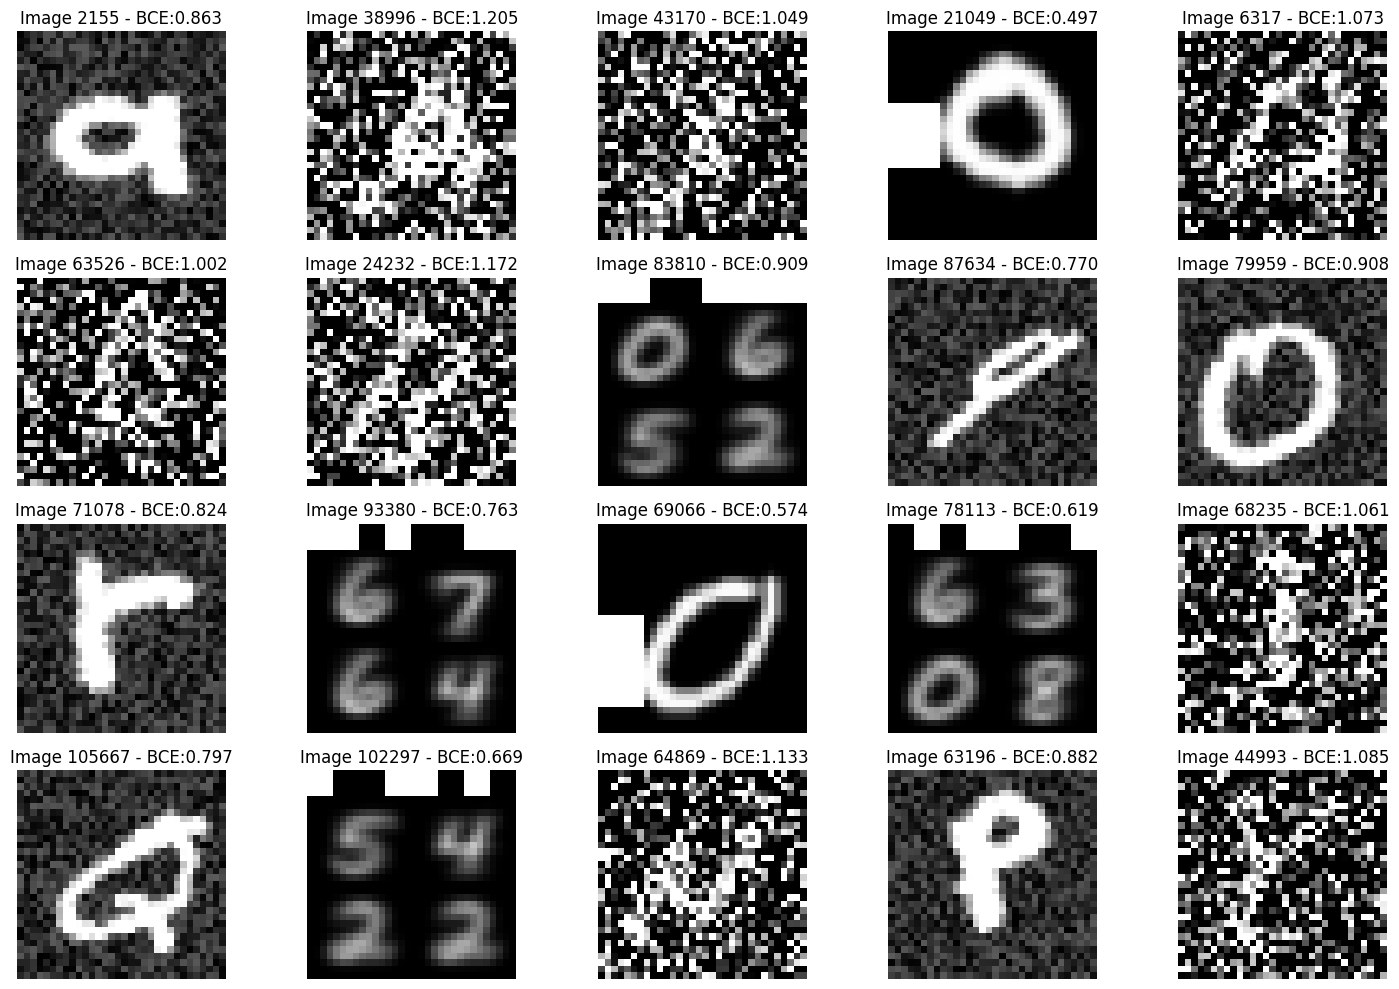

In [ ]:
rows, cols = 4, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()
for i, idx in enumerate(random.sample(corrupted_idx_above_04, rows * cols)):
    img = loaded_corrupted_images[idx]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Image {idx} - BCE:{bce_err_wo_invert[idx]:.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Thanks to the plot above, we think that it exists a correlation betwen the BCE value and the techinque used to corrupt the data.
We thought there are different corruption techniques used :
- Removed part of the Image : 0.5 < BCE < 0.6
- 4 Digits on the Image + missing part : 0.6 < BCE < 0.8
- Add noise on the image (still identifiable) : 0.8 < BCE < 0.9
- Add to many noise (not identifiable) : 1 < BCE < 1.5
- Pixel are invert : BCE > 4

This group are found experimentaly but let's try to cluster the data using weel known clustering algorithm.



1. Using Kmeans  

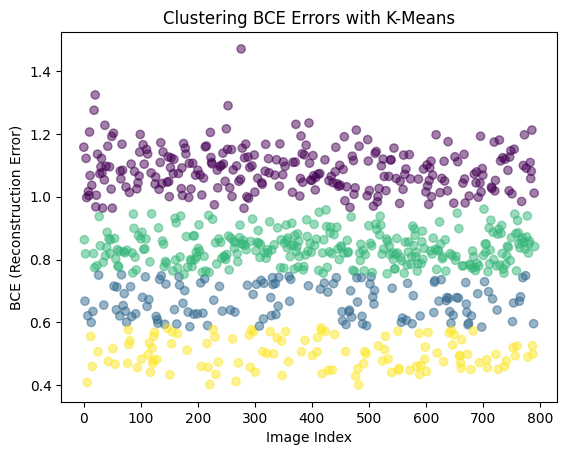

In [ ]:
from sklearn.cluster import KMeans

nb_clusters = 4
threshold = .4

bce_errors = np.array(bce_err_wo_invert)
bce_errors = bce_errors[bce_errors > threshold]
bce_errors = bce_errors.reshape(-1, 1)

kmeans = KMeans(n_clusters=nb_clusters, random_state=0)
clusters = kmeans.fit_predict(bce_errors)

plt.scatter(range(len(bce_errors)), bce_errors, c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel("Image Index")
plt.ylabel("BCE (Reconstruction Error)")
plt.title("Clustering BCE Errors with K-Means")
plt.show()


Results with kmeans seems good, and are inline with experimental analysis.

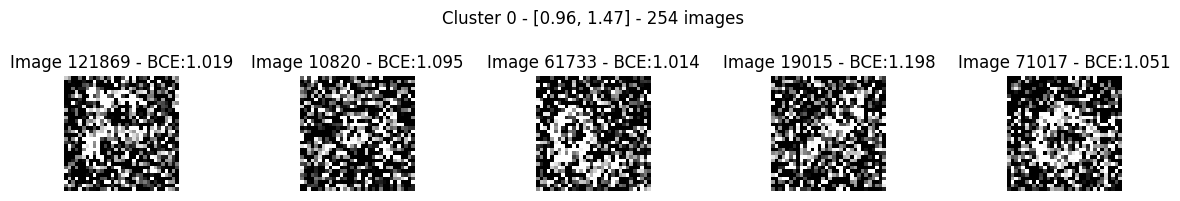

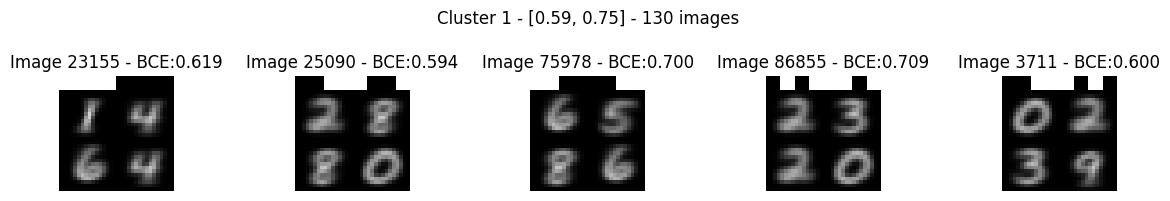

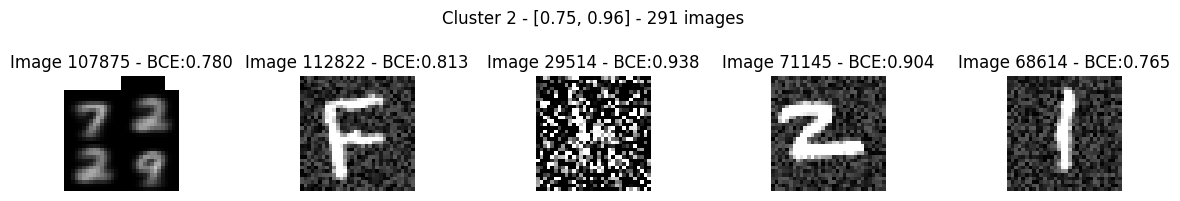

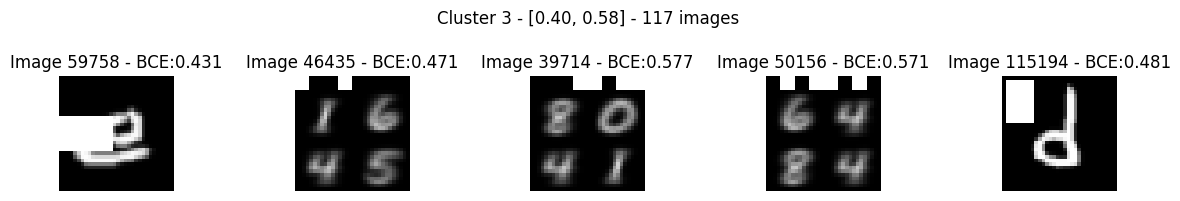

In [ ]:
n_images_per_cluster = 5

for cluster_id in range(nb_clusters):
  # Find indices of images belonging to the current cluster
  cluster_indices = np.where(clusters == cluster_id)[0]

  # Randomly select 5 images from the cluster
  selected_indices = random.sample(list(cluster_indices), min(n_images_per_cluster, len(cluster_indices)))

  # Match with index of the image stored in corrupted_idx_2
  img_idx = [corrupted_idx_above_04[i] for i in selected_indices]

  # Plot the selected images
  fig, axes = plt.subplots(1, n_images_per_cluster, figsize=(12, 2))
  axes = axes.flatten()
  for i, idx in enumerate(img_idx):
    img = loaded_corrupted_images[idx]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Image {idx} - BCE:{bce_err_wo_invert[idx]:.3f}")
    axes[i].axis('off')

  min_bce = np.min(bce_errors[clusters == cluster_id])
  max_bce = np.max(bce_errors[clusters == cluster_id])
  nb_images = sum(clusters == cluster_id)
  plt.suptitle(f"Cluster {cluster_id} - [{min_bce:.2f}, {max_bce:.2f}] - {nb_images} images")
  plt.tight_layout()
  plt.show()

As we can see, clustering on the reconstruction errors is good
- Cluster 0 - $[0.96, 1.47]$: Too noisy images
- Cluster 1 - $[0.59, 0.75]$: 4 digits in the images
- Cluster 2 - $[0.75, 0.96]$: Noisy images
- Cluster 3 - $[0.40, 0.58]$: Missing part on the images

But not perfect since we have the image with 4 digits in different cluster.

2. Using GMM

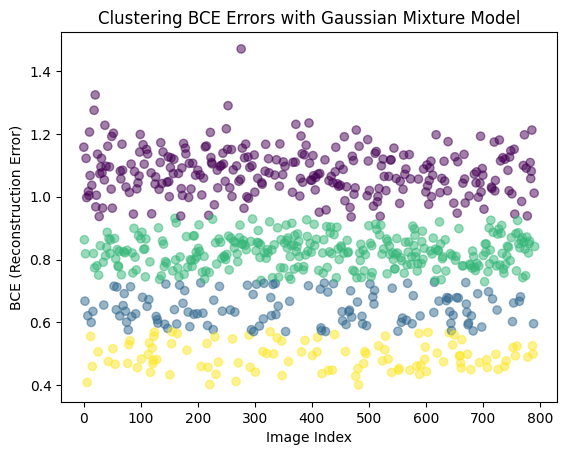

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=0)
clusters = gmm.fit_predict(bce_errors)

plt.scatter(range(len(bce_errors)), bce_errors, c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel("Image Index")
plt.ylabel("BCE (Reconstruction Error)")
plt.title("Clustering BCE Errors with Gaussian Mixture Model")
plt.show()


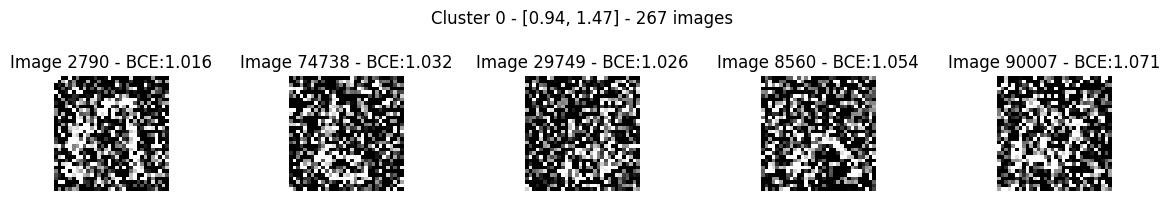

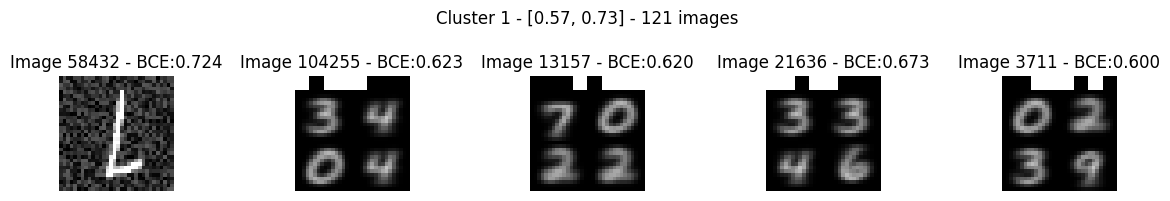

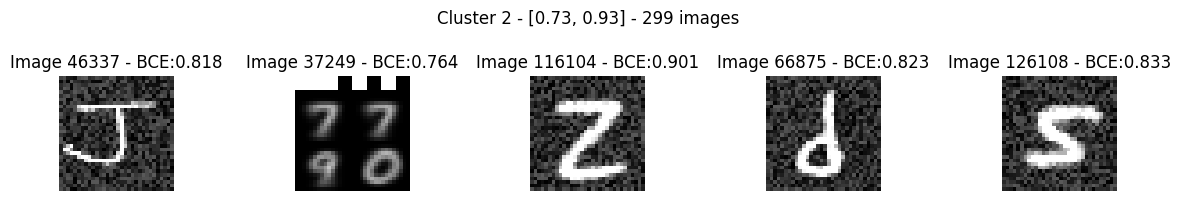

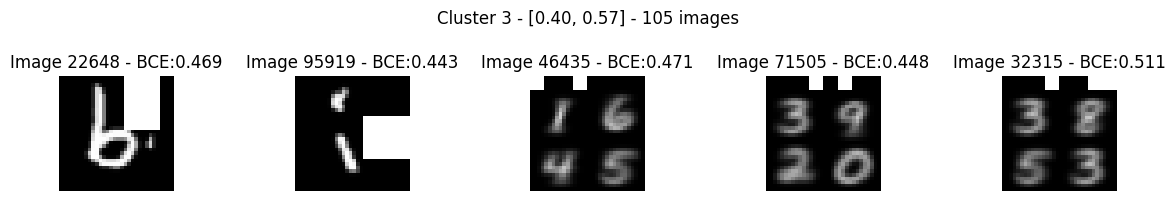

In [ ]:
n_images_per_cluster = 5

for cluster_id in range(nb_clusters):
  # Find indices of images belonging to the current cluster
  cluster_indices = np.where(clusters == cluster_id)[0]

  # Randomly select 5 images from the cluster
  selected_indices = random.sample(list(cluster_indices), min(n_images_per_cluster, len(cluster_indices)))

  # Match with index of the image stored in corrupted_idx_2
  img_idx = [corrupted_idx_above_04[i] for i in selected_indices]

  # Plot the selected images
  fig, axes = plt.subplots(1, n_images_per_cluster, figsize=(12, 2))
  axes = axes.flatten()
  for i, idx in enumerate(img_idx):
    img = loaded_corrupted_images[idx]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Image {idx} - BCE:{bce_err_wo_invert[idx]:.3f}")
    axes[i].axis('off')

  min_bce = np.min(bce_errors[clusters == cluster_id])
  max_bce = np.max(bce_errors[clusters == cluster_id])
  nb_images = sum(clusters == cluster_id)
  plt.suptitle(f"Cluster {cluster_id} - [{min_bce:.2f}, {max_bce:.2f}] - {nb_images} images")
  plt.tight_layout()
  plt.show()

Results are the same as before, clusters seems to be good if we omit images with 4 pixels which are in all the clusters.

And we see some hedge cases that are at the border between two cluster (Image 58432 - with BCE of 0.742 should be in cluster 2)

We also tried DBSCAN but nothing more.

### 6. Reconstruct some anomalies

We understood that in some clusters, images can come from a generative model that haven't finished the process.

For example, images with noise could correspond to a forward process with noise schedeule. The more the noise you have, the latest you are in the forward process.

So to reconstruct from the noise we try to use a denoising autoencoder train on the clean data, and adding noise to train on it.

Contrary to the course, we have chosen to add noise to the image rather than a mask to remove the pixels. Because here we want to denoise an noisy image, not to reconstruct from missing pixels.

We start with a Deep Auto Encoder with linear layer but we notice that the results were not good enough, and that's why we change the architecture. Since we work with images, we move to Convolutional layer.


In [ ]:
def train_denoiser(model, loss_fn, data_loader=None, epochs=1, optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, data in enumerate(train_loader):
            # # Create a random mask to add noise
            # mask = torch.FloatTensor(data.shape).uniform_() > noise

            # Apply the mask to the data
            noisy_data = data + noise * torch.randn(data.size())

            # # Reshape for Linear
            # data = data.view([-1, 1024]).to(device)
            # noisy_data = noisy_data.view([-1, 1024]).to(device)

            # Reshape for Conv2d
            data = data.view([-1, 1, 32, 32]).to(device)
            noisy_data = noisy_data.view([-1, 1, 32, 32]).to(device)

            optimizer.zero_grad()

            # Forward pass with noisy data
            outputs = model.forward(noisy_data)

            # Compute loss between output and original data
            loss = loss_fn(outputs, data)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [ ]:
# Class not used because poor results
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        # Define a deeper encoder with multiple hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        # Define a decoder mirroring the encoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x


class ConvAutoEncoder(nn.Module):
    def __init__(self, input_channels=1, encoding_dim=64, input_dim=1024):
        super(ConvAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(input_dim, encoding_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x


We train the denoiser incrementally adding more noise each time. We start with 0.2 and now are pretty cool result with 0.5

In [ ]:
# Set input dimension and encoding dimension
input_dim = 1024
encoding_dim = 256

# Initialize the DeepAutoEncoder model
# model = DeepAutoEncoder(input_dim, encoding_dim)
model = ConvAutoEncoder(1, encoding_dim, input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

# Train the denoising autoencoder with higher noise level
train_denoiser(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer, noise=0.6)


Train Epoch: 1 [0/112800 (0%)]	Loss: 0.626322
Train Epoch: 1 [25600/112800 (23%)]	Loss: 0.353791
Train Epoch: 1 [51200/112800 (45%)]	Loss: 0.258158
Train Epoch: 1 [76800/112800 (68%)]	Loss: 0.212951
Train Epoch: 1 [102400/112800 (91%)]	Loss: 0.202293
Train Epoch: 2 [0/112800 (0%)]	Loss: 0.198302
Train Epoch: 2 [25600/112800 (23%)]	Loss: 0.189347
Train Epoch: 2 [51200/112800 (45%)]	Loss: 0.183727
Train Epoch: 2 [76800/112800 (68%)]	Loss: 0.184074
Train Epoch: 2 [102400/112800 (91%)]	Loss: 0.177385
Train Epoch: 3 [0/112800 (0%)]	Loss: 0.180581
Train Epoch: 3 [25600/112800 (23%)]	Loss: 0.178203
Train Epoch: 3 [51200/112800 (45%)]	Loss: 0.177971
Train Epoch: 3 [76800/112800 (68%)]	Loss: 0.173889
Train Epoch: 3 [102400/112800 (91%)]	Loss: 0.175202
Train Epoch: 4 [0/112800 (0%)]	Loss: 0.175236
Train Epoch: 4 [25600/112800 (23%)]	Loss: 0.177155
Train Epoch: 4 [51200/112800 (45%)]	Loss: 0.174380
Train Epoch: 4 [76800/112800 (68%)]	Loss: 0.176502
Train Epoch: 4 [102400/112800 (91%)]	Loss: 0.171

In [ ]:
def to_img(x):
    # Convert tensor to NumPy array and move it to CPU
    x = x.cpu().data.numpy()
    # Rescale images to [0,1]
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    # Reshape images to 32x32 pixels
    x = x.reshape([-1, 32, 32])
    return x

We select different corrupted images to conclude on the utility of this denoising model.

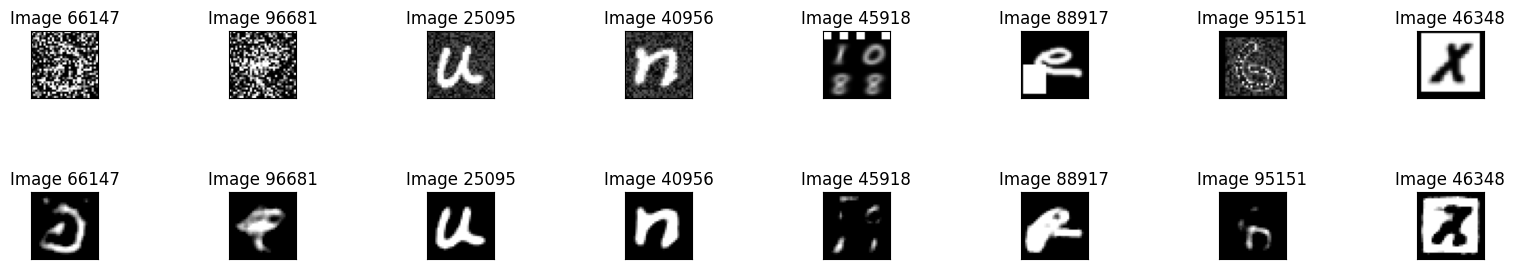

In [ ]:
noisy_index = [66147, 96681, 25095, 40956, 45918, 88917, 95151, 46348]
n = len(noisy_index)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(noisy_index):
    # Select the appropriate image
    noisy_data = corrupted_tensor[idx]
    noisy_data = noisy_data.to(device)
    noisy_data.requires_grad = False
    noisy_data = noisy_data.view([-1, 1, 32, 32])

    # Encode and decode the noisy data
    decoded_imgs = model.forward(noisy_data)
    decoded_imgs = to_img(decoded_imgs)

    # Display noisy images
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(noisy_data.cpu().reshape(32, 32), cmap='gray')
    plt.gray()
    plt.title(f'Image {idx}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed (denoised) images
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(decoded_imgs[0], cmap='gray')
    plt.gray()
    plt.title(f'Image {idx}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

As we can see our denoising auto encoder, performs really well on the 4 first (noisy) images. So we agree to say that the work is done, we succed to denoise some corrupted (noisy) images.

However we have to investigate other methods to:
- separate the 4 digits in 4 images
- Fill a missing part of an image
- inverted images pixels with a black border

We then reconstruct these images by denoising them.

Then we can better investigate the reconstruction errors since there are less corrupted images.

In [ ]:
# Find indices of images belonging to cluster 0 and 2 which are the noisy one
cluster_indices = np.where((clusters == 0) | (clusters == 2))[0]

# Match with index of the image stored in corrupted_idx_above_04
noisy_idx = [corrupted_idx_above_04[i] for i in cluster_indices]

In [ ]:
remaining_corrupted_img = [] #corrupted_images_without_invert.copy()
for idx in corrupted_idx_above_04:
  if idx in noisy_idx:
    # Select the appropriate image
    noisy_data = corrupted_tensor[idx]
    noisy_data = noisy_data.to(device)
    noisy_data.requires_grad = False
    noisy_data = noisy_data.view([-1, 1, 32, 32])

    # Encode and decode the noisy data
    decoded_imgs = model.forward(noisy_data)
    decoded_imgs = to_img(decoded_imgs)

    remaining_corrupted_img.append(decoded_imgs[0])
  else:
    remaining_corrupted_img.append(corrupted_tensor[idx])

In [ ]:
batch_size = 256
remaining_corrupted_tensor = torch.tensor(remaining_corrupted_img, dtype=torch.float32)
remaining_corrupted_loader = torch.utils.data.DataLoader(remaining_corrupted_tensor, batch_size=batch_size)

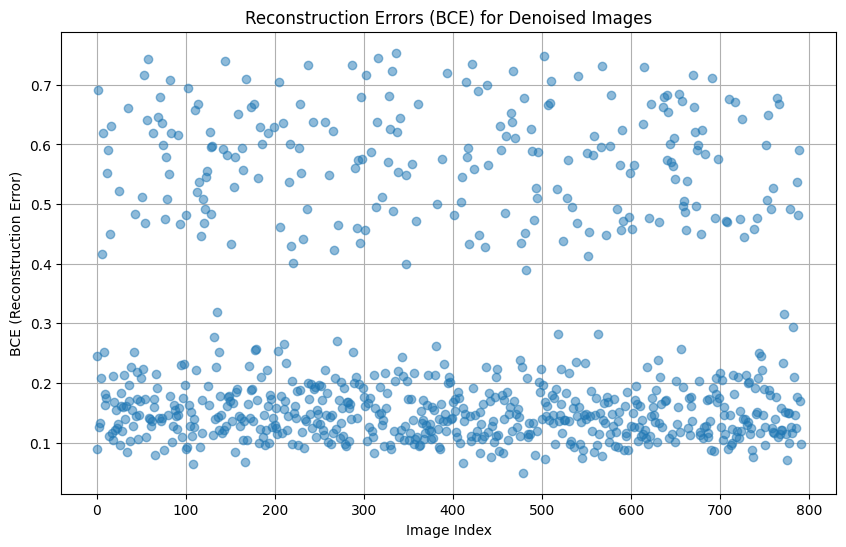

In [ ]:
bce_err_wo_noisy = plot_reconstruction_errors_bce(vae_model, remaining_corrupted_loader, device, dataset='Denoised')

We expected to see a decrease of the BCE only for the image that are reconstructed well (i.e. the noisy one). And it is clearly the case here, the nooisy image move from a BCE above $0.4$ to a BCE under $0.4$ as the clear data. So the job is done to reconstruct those corrupted images.

In [ ]:
threshold = .4
remaining_corrupted_idx = [i for i, v in enumerate(bce_err_wo_noisy) if v > threshold]
print(f'There are {len(remaining_corrupted_idx)} corrupted images with a \
reconstruction errors higher than {threshold} after reconstrucing inverted \
images and noisy one')

There are 225 corrupted images with a reconstruction errors higher than 0.4 after reconstrucing inverted images and noisy one


In this part we succed to reconstruct part of the corrupted images, it remains only $225$ out of the $1033$ initially found ($241$ with inverted pixel and $792$ with a BCE above $0.4$).

To conclude we succed to reconstruct **75%** of the corrupted images that we captured

For further research, we could try and reconstruct images with missing parts using a diffusion model for instance.

# Explore Mode collapse for training a GAN on MNIST

## Train GAN and Explore Mode Collapse

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(0)

%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [ ]:
# Set the root directory for saving the MNIST data
ROOT_DIR = Path.home()
root_dir = os.path.join(ROOT_DIR, 'data/MNIST/')

# Load the MNIST training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Load the MNIST test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.57MB/s]


Extracting /root/data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting /root/data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting /root/data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]

Extracting /root/data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/MNIST/raw



In [ ]:
def generate_samples(generator, num_samples=64, noise_dim=100):
    """
    Visualizes a grid of samples generated by the Generator.

    Args:
        generator (torch.nn.Module): The trained generator model.
        num_samples (int): Total number of samples to generate (must be a square number).
        noise_dim (int): Dimensionality of the noise vector.
    """
    assert int(num_samples**0.5)**2 == num_samples, "num_samples must be a perfect square."

    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim).to(device)
        samples = generator(noise).cpu()
        samples = samples.view(num_samples, 1, 32, 32)

        grid_size = int(num_samples**0.5)
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)

        for i, ax in enumerate(axes.flat):
            ax.imshow(samples[i].squeeze(0), cmap='gray', interpolation='nearest')
            ax.axis('off')

        plt.show()


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_channels=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)



class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

In [ ]:
# Hyperparameters
lr = 2e-4
noise_dim = 100
img_size = 28
channels = 1
epochs = 20
# Initialize models
generator = Generator(noise_dim=noise_dim, out_channels=channels).to(device)
discriminator = Discriminator(in_channels=channels).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

loss_D_epoch = []
loss_G_epoch = []

# Training Loop
for epoch in range(epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0

    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        outputs_real = discriminator(real_imgs)
        loss_real = criterion(outputs_real, real_labels)

        # Fake images
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z)
        outputs_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images and compute generator loss
        outputs_fake = discriminator(fake_imgs)
        loss_G = criterion(outputs_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Accumulate batch losses
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # Store average loss for the epoch
    loss_D_epoch.append(epoch_loss_D / len(train_loader))
    loss_G_epoch.append(epoch_loss_G / len(train_loader))

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"D Loss: {loss_D_epoch[-1]:.4f}, G Loss: {loss_G_epoch[-1]:.4f}"
    )


Epoch [1/20], D Loss: 0.2978, G Loss: 4.6205
Epoch [2/20], D Loss: 0.2374, G Loss: 4.2611
Epoch [3/20], D Loss: 0.1286, G Loss: 4.9301
Epoch [4/20], D Loss: 0.1541, G Loss: 5.6545
Epoch [5/20], D Loss: 0.0380, G Loss: 5.9835
Epoch [6/20], D Loss: 0.1419, G Loss: 6.2281
Epoch [7/20], D Loss: 0.1821, G Loss: 5.8011
Epoch [8/20], D Loss: 0.0166, G Loss: 6.9476
Epoch [9/20], D Loss: 0.0097, G Loss: 7.6908
Epoch [10/20], D Loss: 0.0074, G Loss: 8.0767
Epoch [11/20], D Loss: 0.4341, G Loss: 5.4797
Epoch [12/20], D Loss: 0.0171, G Loss: 6.7911
Epoch [13/20], D Loss: 0.0082, G Loss: 7.6215
Epoch [14/20], D Loss: 0.0054, G Loss: 8.3283
Epoch [15/20], D Loss: 0.0042, G Loss: 8.7581
Epoch [16/20], D Loss: 0.0026, G Loss: 9.2635
Epoch [17/20], D Loss: 0.6123, G Loss: 9.4224
Epoch [18/20], D Loss: 0.0778, G Loss: 5.9042
Epoch [19/20], D Loss: 0.0076, G Loss: 7.7693
Epoch [20/20], D Loss: 0.0022, G Loss: 11.7739


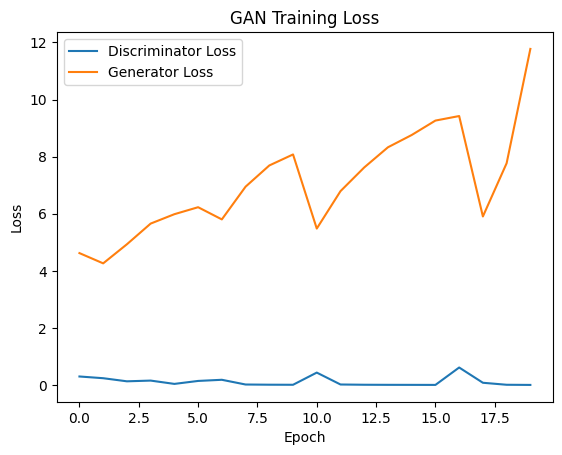

In [ ]:
plt.plot(loss_D_epoch, label='Discriminator Loss')
plt.plot(loss_G_epoch, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.show()

The results show that the discriminator's loss remains low throughout training, suggesting it is highly effective at distinguishing real from fake data. In contrast, the generator's loss steadily increases, with occasional fluctuations, indicating that the generator struggles to improve against the strong discriminator. While the generator's loss reaches high values by the end of training, the results suggest an imbalance between the models, where the discriminator dominates and the generator faces challenges in producing realistic outputs.

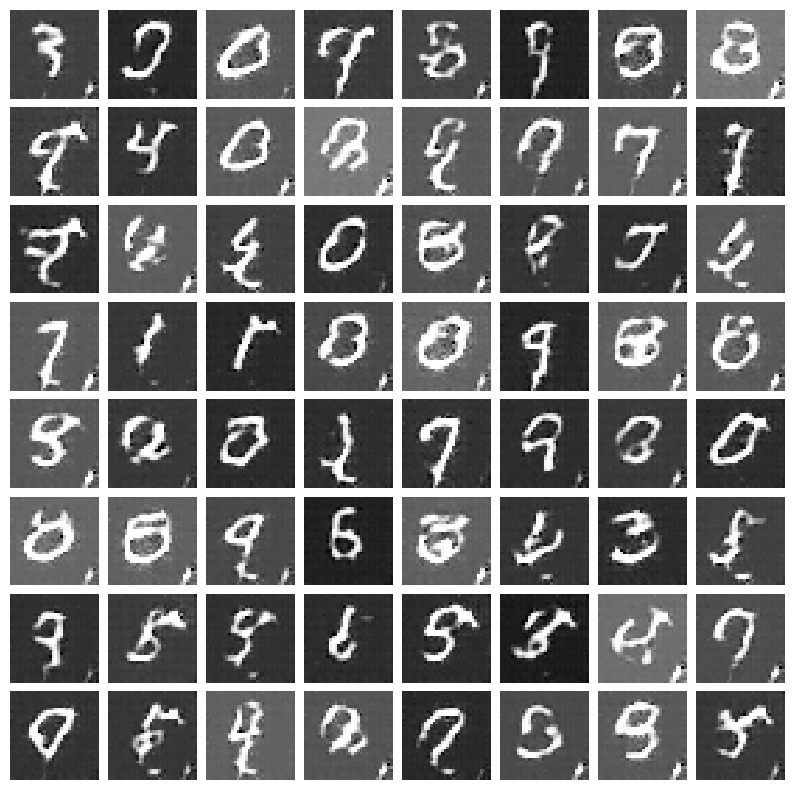

In [ ]:
generate_samples(generator, num_samples=64, noise_dim=100)


By visual inspection, we notice our generator mainly outputs the same numbers (0 and 9). We can suppose this is a sign of mode collapse. The generator creates the same digits more often as it seems to be better at fooling the discriminator, hence it doesn't bother generating a diversity of digits. However, we notice our generator doesn't always produce very convincing images. We will see later with conditional GANs if specifying the label will make our generation have a better quality.



## Evaluate Mode Collapse

While there is no right way of measuring model collapse, we can use qualitative measures such as manually looking at the images and check for mode collapse or not. However, this mainly works if it is self-evident and may fail for more complex cases or more massive amounts of data.

There exist other quantitative measures, such as `Inception Score` (IS) or `Frechet Inception Distance` (FID). IS uses a pre-trained classifier (like Inception v3) and the KL Divergence to measure the quality and diversity of generated samples. FID is a metric used to measure the distance between 2 probability distributions, one representing the real images and the other representing the generated images.

Source: [An empirical study on evaluation metrics of
generative adversarial networks](https://arxiv.org/pdf/1806.07755)

Some other metrics have been tested like `Wasserstein distance` to measure how similar the real and generated distributions are, or the `Mode Coverage` which computes the probability mass of real data that is covered by the generated samples as a measure of the quality of the generator.

Source: [Evaluation of Mode Collapse in Generative
Adversarial Networks](https://ieee-hpec.org/2018/2018program/index_htm_files/124.pdf)

To have a more subtle visual inspection, we can use unsupervised techniques like **Dimension Reduction** and **Clustering**. We will generate fake images using our trained generator and use `t-sne` to plot the generated images in 2D. Then, we can use `DBSCAN` to find clusters of digits based on our samples.

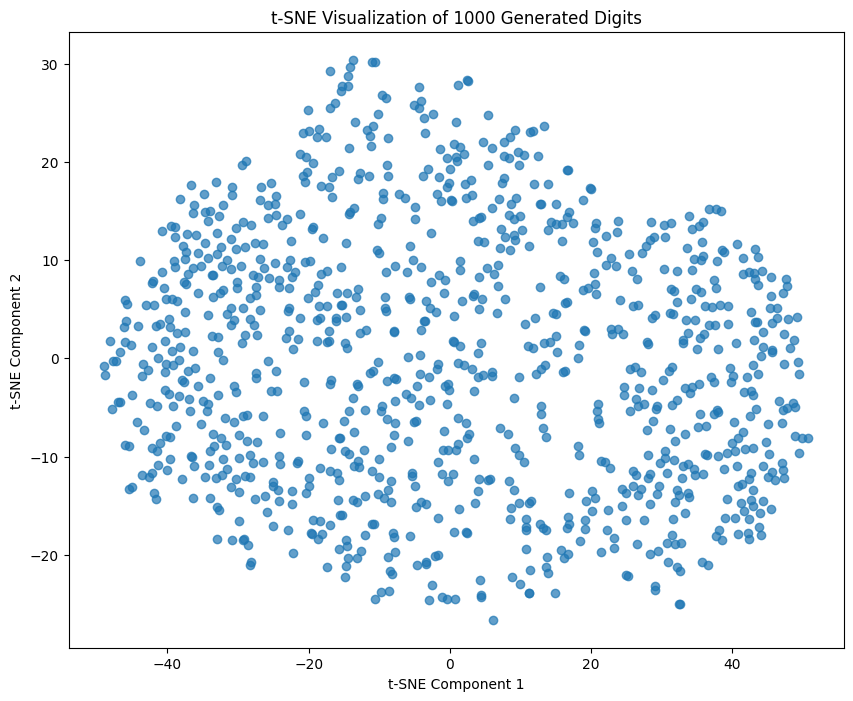

In [ ]:
from sklearn.manifold import TSNE

# Number of samples to generate for t-SNE visualization
num_samples = 1000

# Generate noise
z = torch.randn(num_samples, noise_dim, device=device)

# Generate fake images using the generator
generator.eval()
with torch.no_grad():
    fake_imgs = generator(z).cpu().numpy()

# Flatten the images into feature vectors
fake_imgs_flattened = fake_imgs.reshape(num_samples, -1)

# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(fake_imgs_flattened)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], alpha=0.7
)
plt.title(f"t-SNE Visualization of {num_samples} Generated Digits")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


Without the labels, we cannot identify clusters of digits. Our goal will be to use `DBSCAN` to find these clusters and potentially find an imbalance of generated digits, which would be a clear sign of mode collapse.

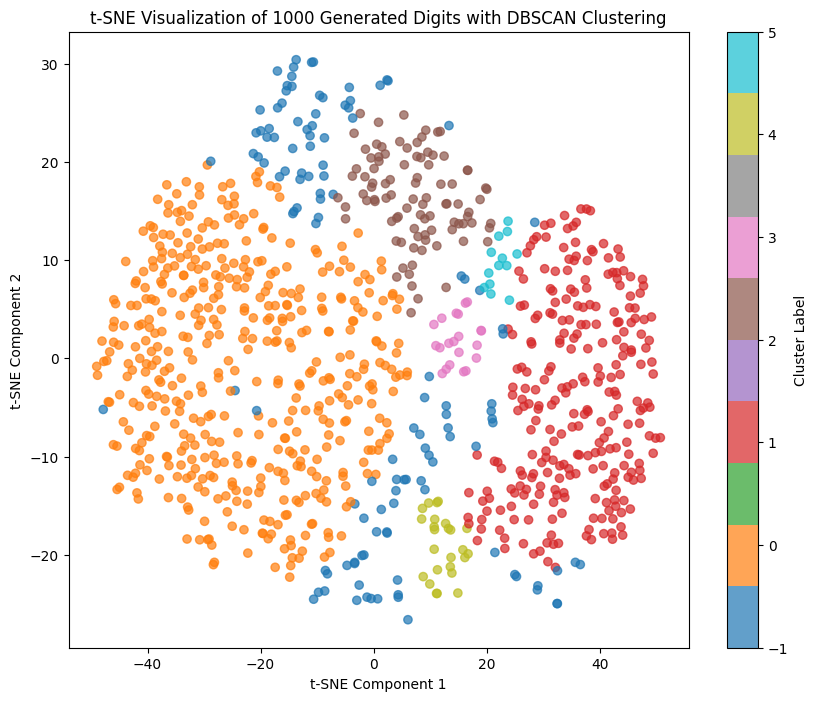

Number of clusters found: 6


In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=20)
cluster_labels = dbscan.fit_predict(tsne_results)

# Plot the t-SNE results with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7
)
plt.colorbar(scatter, label='Cluster Label')
plt.title(f"t-SNE Visualization of {num_samples} Generated Digits with DBSCAN Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Count the number of clusters (excluding noise points labeled as -1)
unique_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found: {unique_clusters}")


As seen above, we identified clusters which are more represented than others (orange and red). This shows that our generator tends to create these digits more often than others, showing clear signs of mode collapse. Notice the blue points are flagged as noise which means DBSCAN doesn't recognize the generated digit.

We will see how we can limit this issue using Conditional GANs.

## Limit Mode Collapse

### Conditional GANs

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10, image_size=28):
        super(ConditionalGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.image_size = image_size

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        out = self.model(x)
        return out.view(out.size(0), 1, self.image_size, self.image_size)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, image_size=28):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.image_size = image_size

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(image_size * image_size + num_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([x, c], dim=1)
        out = self.model(x)
        return out.squeeze()


In [ ]:
# Hyperparameters
noise_dim = 100
num_classes = 10
batch_size = 64
lr = 1e-4
epochs = 20

# Models
generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

loss_D_epoch = []
loss_G_epoch = []

# Training Loop
for epoch in range(epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        # Labels for real and fake data
        real_targets = torch.ones(batch_size, 1).to(device)
        fake_targets = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_output = discriminator(real_images, labels)
        real_loss = criterion(real_output.view(-1, 1), real_targets)

        # Fake images
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_images = generator(z, fake_labels)
        fake_output = discriminator(fake_images.detach(), fake_labels)
        fake_loss = criterion(fake_output.view(-1, 1), fake_targets)

        # Total Discriminator Loss
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        fake_output = discriminator(fake_images, fake_labels)
        loss_G = criterion(fake_output.view(-1, 1), real_targets)
        loss_G.backward()
        optimizer_G.step()

        # Accumulate batch losses
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # Store average loss for the epoch
    loss_D_epoch.append(epoch_loss_D / len(train_loader))
    loss_G_epoch.append(epoch_loss_G / len(train_loader))

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"D Loss: {loss_D_epoch[-1]:.4f}, G Loss: {loss_G_epoch[-1]:.4f}"
    )


Epoch [1/20], D Loss: 0.7309, G Loss: 2.7498
Epoch [2/20], D Loss: 0.4040, G Loss: 4.1927
Epoch [3/20], D Loss: 0.3957, G Loss: 4.3116
Epoch [4/20], D Loss: 0.4444, G Loss: 4.0044
Epoch [5/20], D Loss: 0.4426, G Loss: 3.8947
Epoch [6/20], D Loss: 0.4500, G Loss: 3.7087
Epoch [7/20], D Loss: 0.4980, G Loss: 3.4798
Epoch [8/20], D Loss: 0.4801, G Loss: 3.3872
Epoch [9/20], D Loss: 0.4918, G Loss: 3.2783
Epoch [10/20], D Loss: 0.4879, G Loss: 3.2086
Epoch [11/20], D Loss: 0.5202, G Loss: 3.0636
Epoch [12/20], D Loss: 0.5103, G Loss: 3.0674
Epoch [13/20], D Loss: 0.5368, G Loss: 2.9566
Epoch [14/20], D Loss: 0.5540, G Loss: 2.8537
Epoch [15/20], D Loss: 0.5731, G Loss: 2.7841
Epoch [16/20], D Loss: 0.5761, G Loss: 2.7771
Epoch [17/20], D Loss: 0.5994, G Loss: 2.6962
Epoch [18/20], D Loss: 0.6038, G Loss: 2.6367
Epoch [19/20], D Loss: 0.5779, G Loss: 2.7318
Epoch [20/20], D Loss: 0.5944, G Loss: 2.7276


(-0.5, 301.5, 301.5, -0.5)

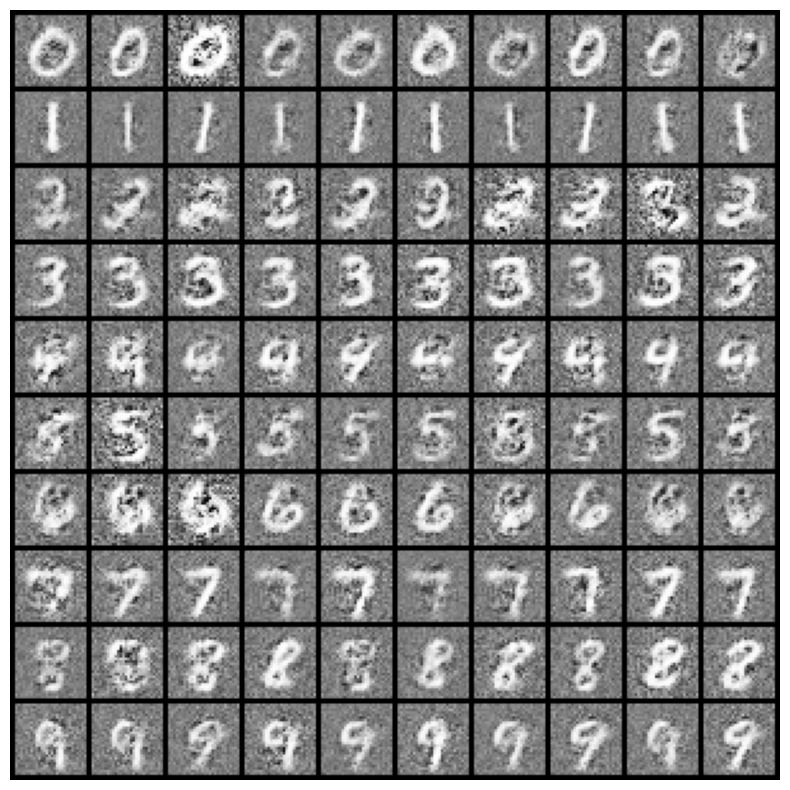

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid

# Generate a batch of random noise vectors for the generator
z = Variable(torch.randn(100, noise_dim)).to(device)

# Generate a batch of labels, one for each class (0-9), repeated 10 times
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

# Generate images using the generator with the noise vectors and class labels
images = generator(z, labels).unsqueeze(1)
images = images.view(images.size(0), 1, 28, 28)

# Create a grid of images for visualization, 10 rows and 10 columns
grid = make_grid(images, nrow=10, normalize=True)

# Plot the grid of images
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='binary')
ax.axis('off')

While not all the digits generated are not of high quality (perhaps we need more epochs), we managed to solve the mode collapse issue by adding labels in our conditional GAN.


### Noise Injection

A low complexity change is to add noise to the discriminator’s input to prevent overfitting and helps stabilize training.
The discriminator learns to distinguish real and fake images under noisy conditions, making it less prone to overfitting. A more robust discriminator helps mitigate mode collapse by pushing the generator to explore diverse outputs.

In [ ]:
def add_noise(images, noise_std=0.1):
    """
    Adds Gaussian noise to images.
    Args:
        images (torch.Tensor): Batch of images (real or generated).
        noise_std (float): Standard deviation of Gaussian noise to add.
    Returns:
        torch.Tensor: Noisy images.
    """
    noise = torch.randn_like(images) * noise_std
    return images + noise


In [ ]:
# Hyperparameters
noise_dim = 100
num_classes = 10
batch_size = 64
lr = 1e-4
epochs = 20

# Models
generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

loss_D_epoch = []
loss_G_epoch = []

# Training Loop with Noise Injection
for epoch in range(epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        # Labels for real and fake data
        real_targets = torch.ones(batch_size, 1).to(device)
        fake_targets = torch.zeros(batch_size, 1).to(device)

        # Add noise to real images
        noisy_real_images = add_noise(real_images)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_output = discriminator(noisy_real_images, labels)
        real_loss = criterion(real_output.view(-1, 1), real_targets)

        # Fake images
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_images = generator(z, fake_labels)

        # Add noise to fake images
        noisy_fake_images = add_noise(fake_images)

        fake_output = discriminator(noisy_fake_images.detach(), fake_labels)
        fake_loss = criterion(fake_output.view(-1, 1), fake_targets)

        # Total Discriminator Loss
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        fake_output = discriminator(noisy_fake_images, fake_labels)
        loss_G = criterion(fake_output.view(-1, 1), real_targets)
        loss_G.backward()
        optimizer_G.step()

        # Accumulate batch losses
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # Store average loss for the epoch
    loss_D_epoch.append(epoch_loss_D / len(train_loader))
    loss_G_epoch.append(epoch_loss_G / len(train_loader))

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"D Loss: {loss_D_epoch[-1]:.4f}, G Loss: {loss_G_epoch[-1]:.4f}"
    )


Epoch [1/20], D Loss: 0.8625, G Loss: 2.1579
Epoch [2/20], D Loss: 0.5226, G Loss: 3.3549
Epoch [3/20], D Loss: 0.4843, G Loss: 3.6009
Epoch [4/20], D Loss: 0.5257, G Loss: 3.3878
Epoch [5/20], D Loss: 0.5319, G Loss: 3.2925
Epoch [6/20], D Loss: 0.5476, G Loss: 3.1515
Epoch [7/20], D Loss: 0.5849, G Loss: 2.9184
Epoch [8/20], D Loss: 0.5974, G Loss: 2.7903
Epoch [9/20], D Loss: 0.6075, G Loss: 2.7161
Epoch [10/20], D Loss: 0.6236, G Loss: 2.5912
Epoch [11/20], D Loss: 0.6257, G Loss: 2.5541
Epoch [12/20], D Loss: 0.6779, G Loss: 2.4036
Epoch [13/20], D Loss: 0.6796, G Loss: 2.3958
Epoch [14/20], D Loss: 0.7006, G Loss: 2.3169
Epoch [15/20], D Loss: 0.7281, G Loss: 2.2317
Epoch [16/20], D Loss: 0.7306, G Loss: 2.2196
Epoch [17/20], D Loss: 0.7492, G Loss: 2.1697
Epoch [18/20], D Loss: 0.7547, G Loss: 2.1477
Epoch [19/20], D Loss: 0.7626, G Loss: 2.1280
Epoch [20/20], D Loss: 0.7568, G Loss: 2.1402


(-0.5, 301.5, 301.5, -0.5)

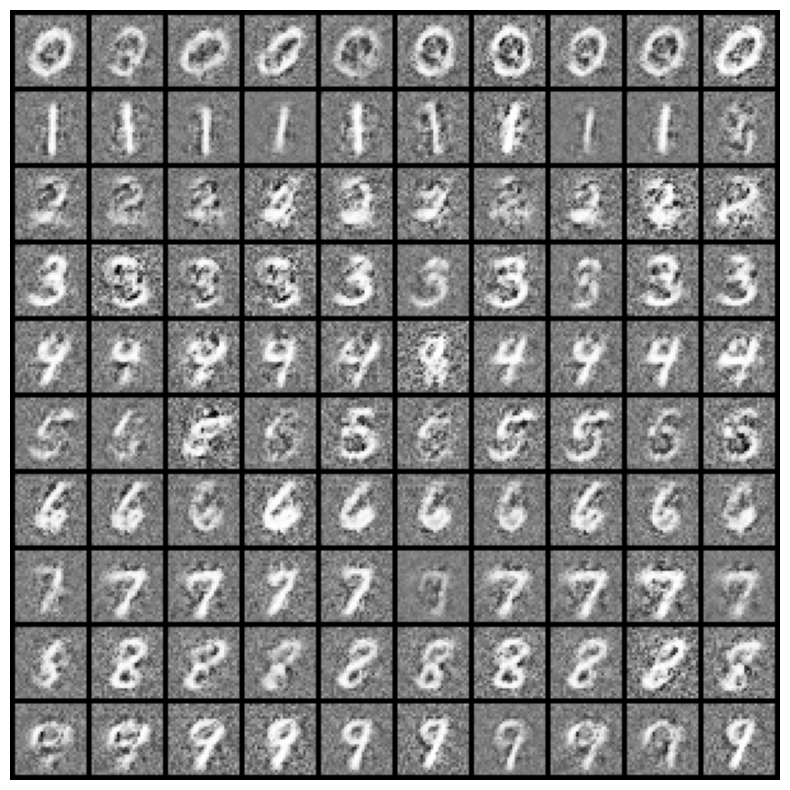

In [ ]:
# Generate a batch of random noise vectors for the generator
z = Variable(torch.randn(100, noise_dim)).to(device)

# Generate a batch of labels, one for each class (0-9), repeated 10 times
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

# Generate images using the generator with the noise vectors and class labels
images = generator(z, labels).unsqueeze(1)
images = images.view(images.size(0), 1, 28, 28)

# Create a grid of images for visualization, 10 rows and 10 columns
grid = make_grid(images, nrow=10, normalize=True)

# Plot the grid of images
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='binary')
ax.axis('off')

Results seem more or less similar as before without noise injection. We could've attempted to run the training for more epochs as GAN's might require more training to effectively generate quality images. However, due to our GPU access limitations, we thought the generated images were convincing enough.

## Extension to Other Datasets

In [ ]:
# Load CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root="./data", train=True, transform=transforms.ToTensor(), download=True)
dataloader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:02<00:00, 68.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


CIFAR-10 images differ from MNIST in several ways:

    CIFAR-10: 3 channels (RGB), 32x32 pixels.
    MNIST: 1 channel (grayscale), 28x28 pixels.

In [ ]:
# Hyperparameters
lr = 2e-4
noise_dim = 100
img_size = 32 # Change image size to 32
channels = 3 # Change channels to 3
epochs = 50 # Increase epochs

# Initialize models
generator = Generator(noise_dim=noise_dim, out_channels=channels).to(device)
discriminator = Discriminator(in_channels=channels).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

loss_D_epoch = []
loss_G_epoch = []

# Training Loop
for epoch in range(epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0

    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        outputs_real = discriminator(real_imgs)
        loss_real = criterion(outputs_real, real_labels)

        # Fake images
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_imgs = generator(z)
        outputs_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images and compute generator loss
        outputs_fake = discriminator(fake_imgs)
        loss_G = criterion(outputs_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Accumulate batch losses
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # Store average loss for the epoch
    loss_D_epoch.append(epoch_loss_D / len(dataloader))
    loss_G_epoch.append(epoch_loss_G / len(dataloader))

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"D Loss: {loss_D_epoch[-1]:.4f}, G Loss: {loss_G_epoch[-1]:.4f}"
    )


Epoch [1/50], D Loss: 1.3670, G Loss: 0.9347
Epoch [2/50], D Loss: 1.2066, G Loss: 1.2603
Epoch [3/50], D Loss: 1.1136, G Loss: 1.3356
Epoch [4/50], D Loss: 1.0095, G Loss: 1.5730
Epoch [5/50], D Loss: 0.9682, G Loss: 1.5954
Epoch [6/50], D Loss: 0.9249, G Loss: 1.7136
Epoch [7/50], D Loss: 0.9043, G Loss: 1.7800
Epoch [8/50], D Loss: 0.9099, G Loss: 1.7903
Epoch [9/50], D Loss: 0.9172, G Loss: 1.7930
Epoch [10/50], D Loss: 0.9175, G Loss: 1.8392
Epoch [11/50], D Loss: 0.9230, G Loss: 1.8378
Epoch [12/50], D Loss: 0.9159, G Loss: 1.8404
Epoch [13/50], D Loss: 0.9307, G Loss: 1.8189
Epoch [14/50], D Loss: 0.9153, G Loss: 1.8586
Epoch [15/50], D Loss: 0.9158, G Loss: 1.8797
Epoch [16/50], D Loss: 0.9148, G Loss: 1.8612
Epoch [17/50], D Loss: 0.9331, G Loss: 1.8684
Epoch [18/50], D Loss: 0.9054, G Loss: 1.8848
Epoch [19/50], D Loss: 0.9150, G Loss: 1.9047
Epoch [20/50], D Loss: 0.9114, G Loss: 1.9174
Epoch [21/50], D Loss: 0.9179, G Loss: 1.9177
Epoch [22/50], D Loss: 0.9321, G Loss: 1.92

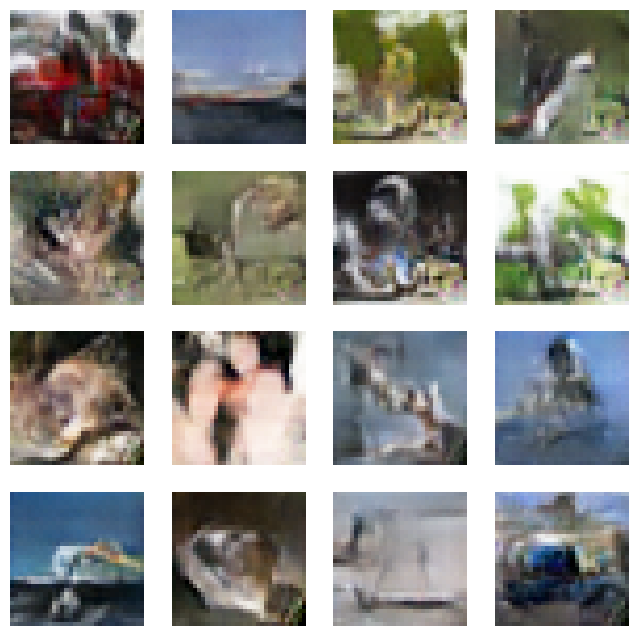

In [ ]:
def visualize_images(images, n_row=4, n_col=4):
    fig, axes = plt.subplots(n_row, n_col, figsize=(8, 8))
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            img = images[idx].permute(1, 2, 0).cpu().detach().numpy()
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.show()

z = torch.randn(16, noise_dim, device=device)
fake_imgs = generator(z)
visualize_images(fake_imgs)

This was more meant as a test to see if our small changes (image size and channels) were well adapted for a dataset like CIFAR-10. Indeed, the training works. However, we most likely need more epochs for our generator to produce higher quality images. As we've seen in class, one of the drawbacks, for both CIFAR-10 and MNIST, was the training instability due to GAN's adversarial nature, making it complicated to balance the tuning of the generator and discriminator.

## GAN vs VAE vs Diffusion

As seen in class, each model has its strengths and limitations. We summarize key aspects of comparison in the table below.

| **Aspect**                | **GANs**                                   | **VAEs**                                   | **Diffusion Models**                          |
|---------------------------|--------------------------------------------|--------------------------------------------|-----------------------------------------------|
| **Core Mechanism**        | Adversarial game between generator and discriminator. | Probabilistic encoder-decoder with latent Gaussian prior. | Iterative denoising to reverse noise addition. |
| **Training Stability**    | Challenging (prone to mode collapse and adversarial instability). | Easier (stable optimization with clear objectives). | Stable, but computationally expensive.         |
| **Sample Quality**        | High (sharp and realistic).                | Medium (blurry due to reconstruction loss).| Very High (diverse, crisp, and detailed).      |
| **Sampling Speed**        | Very Fast (single forward pass).           | Very Fast (single forward pass).           | Slow (requires iterative denoising steps).     |
| **Latent Space Structure**| Implicit (no explicit prior).              | Explicit (Gaussian prior enables smooth interpolation). | Implicit (complex learned distributions).      |
| **Expressiveness**        | High (captures complex data distributions).| Medium (limited by Gaussian assumptions).  | Very High (handles highly complex distributions).  |
| **Mode Collapse**         | Risk of mode collapse (produces fewer modes).| Limited (trained to preserve diversity).   | No collapse (samples represent full diversity). |
| **Training Time**         | Medium (fewer iterations, requires tuning).| Fast (relatively low computational cost).  | Long (due to iterative training process).      |
| **Memory Usage**          | Medium (moderate model size).              | Low (efficient memory use).                | High (many intermediate steps).                |
| **Implementation Complexity**| Medium (requires careful design of generator/discriminator). | Low (simple encoder-decoder architecture). | High (complex iterative process).              |
| **Best Use Cases**        | High-resolution image generation, style transfer, image-to-image translation. | Representation learning, latent exploration, smooth interpolation. | Photorealistic image generation, scientific simulations. |
| **Strengths**             | Sharp and realistic outputs.             | Smooth latent space traversal.           | Exceptionally detailed and diverse outputs.  |               
| **Limitations**           | Training instability (adversarial nature), Mode Collapse.                    | Blurry samples.                          | Computationally intensive                               |
| **Examples**              | Generating realistic faces, high-resolution, style transfer. | Generating variations of data, anomaly detection, semi-supervised learning. | Text-to-image models (e.g. DALL-E). |